<a href="https://colab.research.google.com/github/AbbasGhalib/InAndOut/blob/master/AML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## British Airways Sentiment Analysis and Feature Ranking


In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import requests
import time
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [3]:
# NLP Libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Ensure NLTK resources are downloaded
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)

True

In [4]:
# ML libraries
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE

# For handling class imbalance
from imblearn.over_sampling import SMOTE

In [5]:
# For visualization
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

# For model interpretation
import shap
from sklearn.tree import plot_tree

# XGBoost for learning-to-rank
import xgboost as xgb

# Set random seed for reproducibility
np.random.seed(42)

######################################
# PART 1: DATA COLLECTION
######################################

In [6]:
# Note: This part can be commented out if you've already scraped the data
def scrape_reviews(total_pages=345):
    """
    Scrape British Airways reviews from airlinequality.com

    Args:
        total_pages (int): Number of pages to scrape

    Returns:
        pandas.DataFrame: Dataframe containing scraped reviews
    """
    df = pd.DataFrame(columns=['Rating', 'Title', 'Reviewer', 'Verified', 'Review',
                              'Date_Published', 'Aircraft', 'Type_of_Traveller',
                              'Seat_Type', 'Flight_From', 'Flight_To', 'Date_Flown',
                              'Seat_Comfort_Rating', 'Cabin_Staff_Service_Rating',
                              'Food_and_Beverages_Rating', 'Inflight_Entertainment_Rating',
                              'Ground_Service_Rating', 'Wifi_and_Connectivity_Rating',
                              'Value_for_Money_Rating', 'Recommended'])

    for i in range(1, total_pages):
        url = f'https://www.airlinequality.com/airline-reviews/british-airways/page/{i}/'
        page = requests.get(url)
        soup = BeautifulSoup(page.content, 'html.parser')
        articles = soup.find_all('article', class_="comp_media-review-rated")

        for article in articles:
            rating = None
            if article.find('span', itemprop="ratingValue"):
                rating = article.find('span', itemprop="ratingValue").text

            title = article.find('h2', class_="text_header").text
            reviewer = article.find('span', itemprop="name").text

            verified = None
            if article.find("em"):
                verified = article.find("em").text

            review = article.find("div", class_="text_content").text
            review = review.partition("| ")[2]

            date_published = article.find('time', itemprop="datePublished").text

            aircraft = article.find('td', string="Aircraft", class_="review-rating-header")
            if aircraft:
                aircraft = aircraft.find_next_sibling('td').text
            else:
                aircraft = None

            type_of_traveller = article.find('td', class_="type_of_traveller")
            if type_of_traveller:
                type_of_traveller = type_of_traveller.find_next_sibling('td').text
            else:
                type_of_traveller = None

            seat_type = article.find('td', class_="cabin_flown")
            if seat_type:
                seat_type = seat_type.find_next_sibling('td').text
            else:
                seat_type = None

            route = article.find('td', class_="route")
            if route:
                route = route.find_next_sibling('td').text
                flight_from = route.split(" ")[0]
                flight_to = route.partition("to ")[2]
            else:
                flight_from = None
                flight_to = None

            date_flown = article.find('td', class_="date_flown")
            if date_flown:
                date_flown = date_flown.find_next_sibling('td').text
            else:
                date_flown = None

            # Extract ratings
            seat_comfort_rating = extract_rating(article, 'seat_comfort')
            cabin_staff_service_rating = extract_rating(article, 'cabin_staff_service')
            food_and_beverages_rating = extract_rating(article, 'food_and_beverages')
            inflight_entertainment_rating = extract_rating(article, 'inflight_entertainment')
            ground_service_rating = extract_rating(article, 'ground_service')
            wifi_and_connectivity_rating = extract_rating(article, 'wifi_and_connectivity')
            value_for_money_rating = extract_rating(article, 'value_for_money')

            recommended = article.find('td', class_="recommended")
            if recommended:
                recommended = recommended.find_next_sibling('td').text
            else:
                recommended = None

            info = [rating, title, reviewer, verified, review, date_published, aircraft, type_of_traveller,
                   seat_type, flight_from, flight_to, date_flown, seat_comfort_rating, cabin_staff_service_rating,
                   food_and_beverages_rating, inflight_entertainment_rating, ground_service_rating,
                   wifi_and_connectivity_rating, value_for_money_rating, recommended]

            df.loc[len(df)] = info

        print(f"Scraped page {i} of {total_pages}")
        time.sleep(5)  # Polite delay between requests

    return df

def extract_rating(article, class_name):
    """
    Extract rating from article based on class name

    Args:
        article: BeautifulSoup article element
        class_name: Class name of the rating element

    Returns:
        int: Rating value (number of filled stars)
    """
    element = article.find('td', class_=class_name)
    if element:
        rating_container = element.find_next_sibling('td')
        return len(rating_container.find_all('span', class_="fill"))
    else:
        return None

# Uncomment to scrape data
df = scrape_reviews(total_pages=5)  # Set lower for testing
df.to_csv("BA_DATA.csv", index=False)

# Load the data (assumes data is already scraped)
# If you've already scraped and saved the data, load it directly
df = pd.read_csv("BA_DATA.csv")

Scraped page 1 of 5
Scraped page 2 of 5
Scraped page 3 of 5
Scraped page 4 of 5


########################################
# PART 2: DATA PREPROCESSING
########################################

In [7]:
def clean_text(text):
    """
    Clean and preprocess text data

    Args:
        text (str): Text to preprocess

    Returns:
        str: Preprocessed text
    """
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()

        # Remove URLs
        text = re.sub(r'http\S+|www.\S+', '', text)

        # Remove newlines
        text = re.sub(r'\n', ' ', text)

        # Remove punctuation
        text = re.sub(r'[^\w\s]', ' ', text)

        # Remove integers
        text = re.sub(r'\d', '', text)

        # Remove emojis
        text = re.sub(r'[^\w\s#@/:%.,_-]', ' ', text, flags=re.UNICODE)

        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        return text
    return ""

# Clean review text
df['Cleaned_Review'] = df['Review'].apply(clean_text)

# Handle missing values
# Find records with no reviews
null_reviews = df.loc[df['Cleaned_Review'].isnull()]
print(f"Number of null reviews: {len(null_reviews)}")

# Drop rows where both Review and Title are 'British Airways customer review'
df = df.drop(df[(df['Cleaned_Review'].isnull()) & (df['Title'] == 'British Airways customer review')].index)

# Replace reviews with titles where review is null
df.loc[df["Cleaned_Review"].isnull(), "Cleaned_Review"] = df.loc[df["Cleaned_Review"].isnull(), "Title"].apply(clean_text)

# Drop irrelevant columns
df = df.drop(['Reviewer', 'Date_Published', 'Date_Flown', 'Verified'], axis=1)

Number of null reviews: 0


###############################################################
# PART 3: TOKENIZATION AND STOPWORD REMOVAL
###############################################################

In [9]:
print(nltk.data.find('tokenizers/punkt'))

/root/nltk_data/tokenizers/punkt


In [8]:
from nltk.tokenize import TreebankWordTokenizer

# Define English stopwords
stop_words = set(stopwords.words("english"))

# Add custom stopwords
custom_stopwords = ['the', 'a', 'us', 'sold', 'of', 'in', 'created', 'me', 'you', 'be',
                   'very', 'so', 'are', 'an', 'which', 'good', 'british', 'airways', 'ba',
                   'flight', 'get', 'would', 'well', 'check', 'airline', 'great', 't', 'for',
                   'with', 'but', 'this', 'an', 'it', 'is', 'from', 'to', 'i', 'in', 'that',
                   'made', 'after', 'their', 'his', 'only', 'previously', 'leaving', 'one',
                   'first', 'back', 'hours', 'even', 'told']
stop_words = stop_words.union(custom_stopwords)

def remove_stopwords(text):
    """
    Remove stopwords from text

    Args:
        text (str): Input text

    Returns:
        str: Text with stopwords removed
    """
    return ' '.join([word for word in text.split() if word not in stop_words])

# Remove stopwords
df['Filtered_Review'] = df['Cleaned_Review'].apply(remove_stopwords)

# Tokenize words
tokenizer = TreebankWordTokenizer()

df['Token_Words'] = df['Filtered_Review'].apply(lambda x: tokenizer.tokenize(str(x)))


# Apply lemmatization
lemmatizer = WordNetLemmatizer()

def lemmatize_text(tokens):
    """
    Lemmatize tokens

    Args:
        tokens (list): List of tokens

    Returns:
        list: List of lemmatized tokens
    """
    return [lemmatizer.lemmatize(token) for token in tokens]

df['Lemmatized_Tokens'] = df['Token_Words'].apply(lemmatize_text)
df['Lemmatized_Text'] = df['Lemmatized_Tokens'].apply(lambda x: ' '.join(x))


######################################
# PART 4: SENTIMENT ANALYSIS
######################################

In [9]:
!pip uninstall -y flair
!pip uninstall -y transformers tokenizers
!pip install --no-cache-dir transformers==4.41.0 tokenizers


Found existing installation: transformers 4.41.0
Uninstalling transformers-4.41.0:
  Successfully uninstalled transformers-4.41.0
Found existing installation: tokenizers 0.19.1
Uninstalling tokenizers-0.19.1:
  Successfully uninstalled tokenizers-0.19.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 147.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 291.2 MB/s eta 0:00:00


In [10]:
from transformers import pipeline
classifier = pipeline("sentiment-analysis")

def flair_prediction(x):
    try:
        result = classifier(x[:512])[0]  # Truncate to 512 tokens
        if result['label'] == 'POSITIVE':
            return 1
        elif result['label'] == 'NEGATIVE':
            return -1
        else:
            return 0
    except:
        return 0

# Apply sentiment analysis
df['Sentiment_Score'] = df['Filtered_Review'].apply(flair_prediction)

# Create a binary sentiment label
df['Sentiment_Label'] = df['Sentiment_Score'].apply(lambda x: 1 if x > 0 else 0)

# View sentiment distribution
sentiment_counts = df['Sentiment_Label'].value_counts()
print("Sentiment Distribution:")
print(sentiment_counts)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Sentiment Distribution:
Sentiment_Label
0    24
1    16
Name: count, dtype: int64


########################################
# PART 5: FEATURE ENGINEERING
########################################

In [11]:
# Convert categorical features to numerical
categorical_features = ['Seat_Type', 'Type_of_Traveller', 'Aircraft', 'Flight_From', 'Flight_To', 'Recommended']

# Function to encode categorical features
def encode_categorical_features(df, categorical_cols):
    """
    Encode categorical features

    Args:
        df (pandas.DataFrame): Input dataframe
        categorical_cols (list): List of categorical column names

    Returns:
        pandas.DataFrame: Dataframe with encoded features
        dict: Dictionary of encoders
    """
    encoders = {}
    df_encoded = df.copy()

    for col in categorical_cols:
        if col in df.columns:
            # Fill missing values with 'Unknown'
            df_encoded[col] = df_encoded[col].fillna('Unknown')

            # Create and fit encoder
            encoder = LabelEncoder()
            df_encoded[col + '_Encoded'] = encoder.fit_transform(df_encoded[col])
            encoders[col] = encoder

    return df_encoded, encoders

df_encoded, encoders = encode_categorical_features(df, categorical_features)

# Create features from ratings
rating_features = ['Seat_Comfort_Rating', 'Cabin_Staff_Service_Rating',
                  'Food_and_Beverages_Rating', 'Inflight_Entertainment_Rating',
                  'Ground_Service_Rating', 'Wifi_and_Connectivity_Rating',
                  'Value_for_Money_Rating']

# Fill NaN values with median for rating features
for col in rating_features:
    if col in df_encoded.columns:
        df_encoded[col] = df_encoded[col].fillna(df_encoded[col].median())

# Create TF-IDF vectors from lemmatized text
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
tfidf_features = tfidf_vectorizer.fit_transform(df_encoded['Lemmatized_Text'])

# Get feature names
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# Create a DataFrame with TF-IDF features
tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=tfidf_feature_names)

# Print the shape of TF-IDF features
print(f"TF-IDF features shape: {tfidf_features.shape}")

TF-IDF features shape: (40, 3093)


##############################################################
# PART 6: DIMENSIONALITY REDUCTION WITH PCA
##############################################################

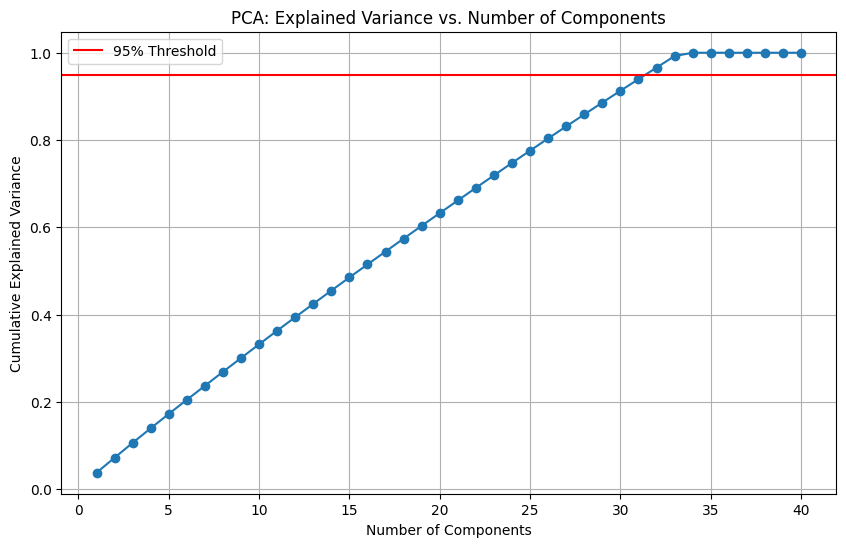

Number of components needed to explain 95% of the variance: 32


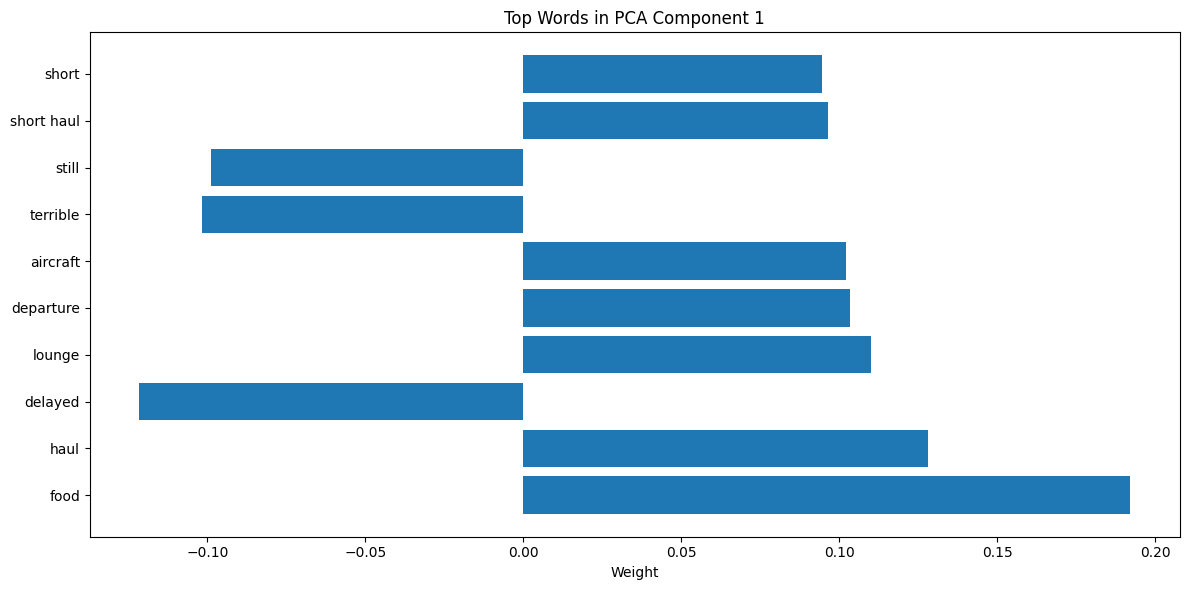

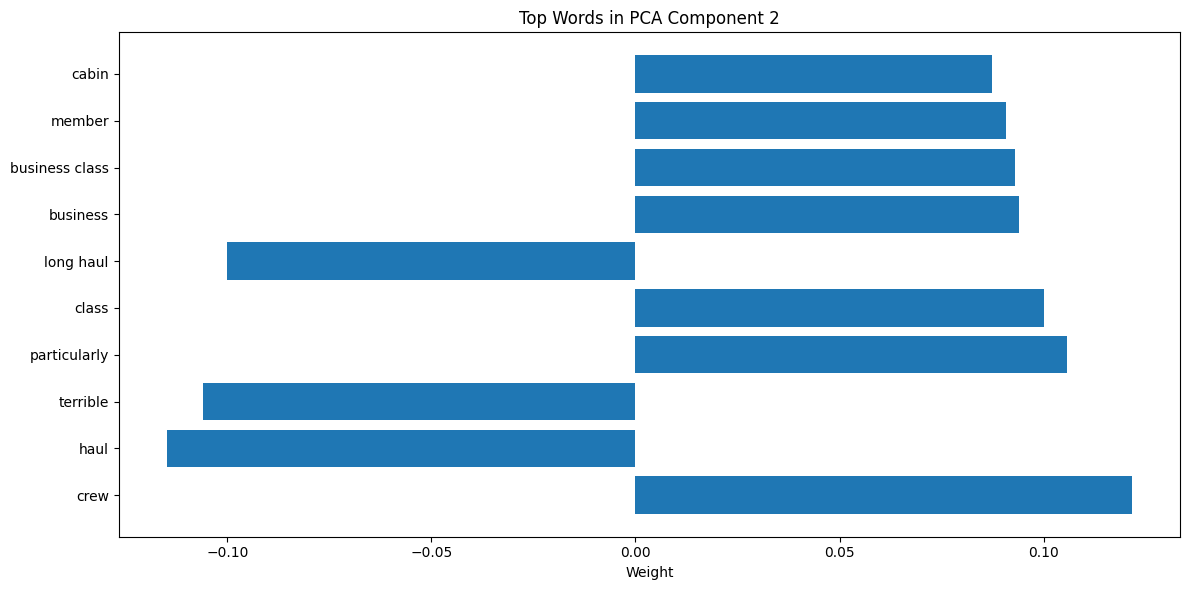

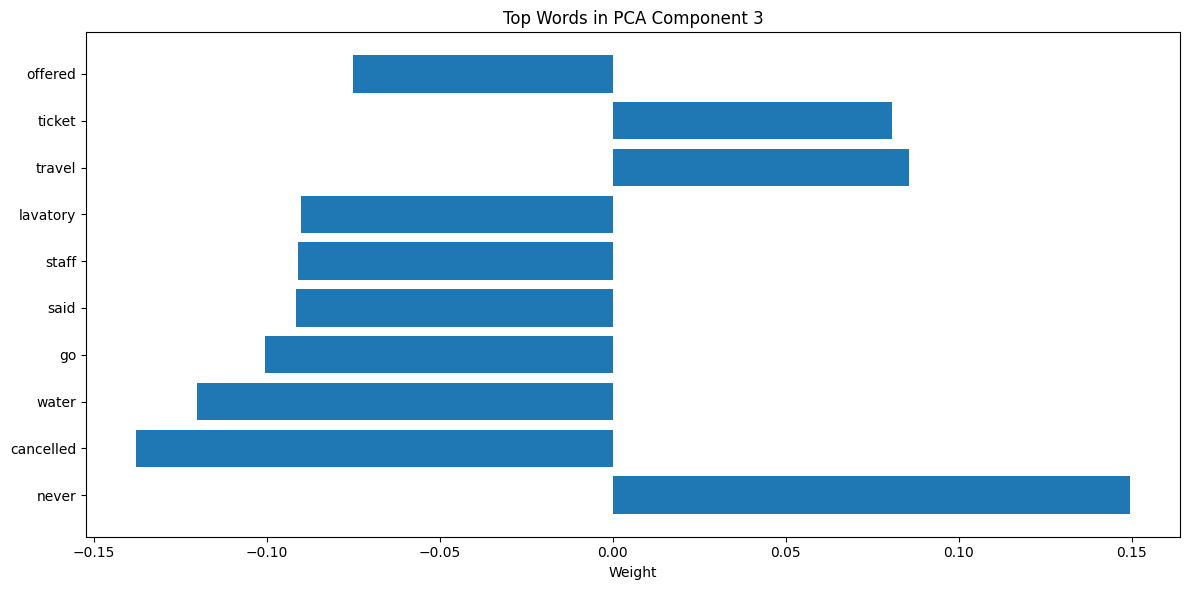

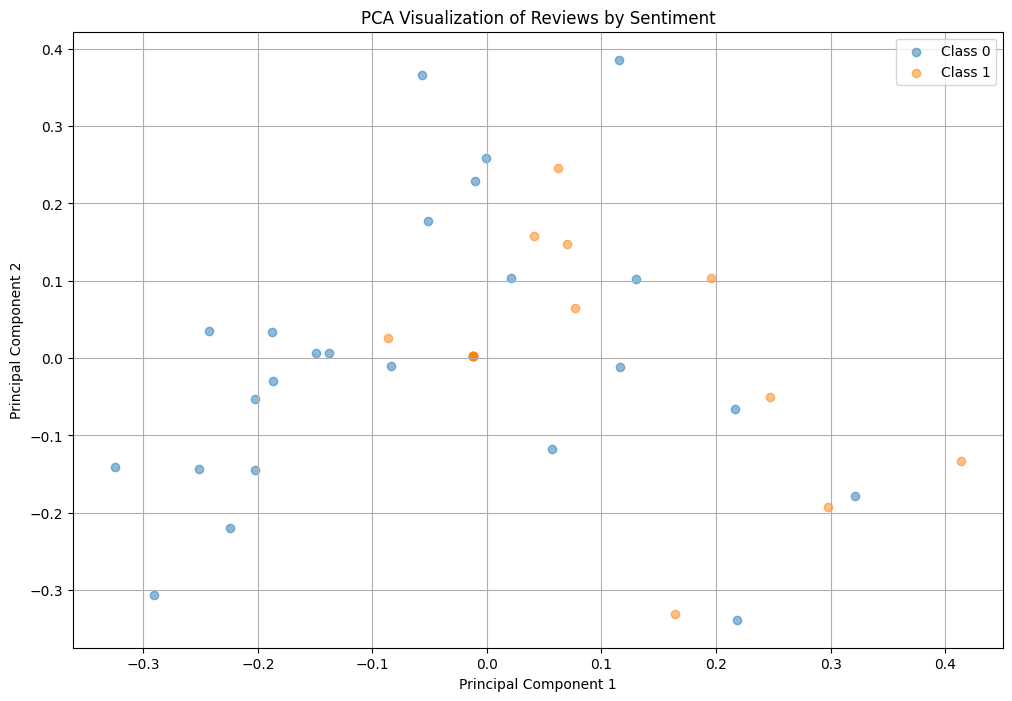

In [15]:
# Apply PCA to TF-IDF features
def apply_pca(features, n_components=100):
    """
    Apply PCA for dimensionality reduction

    Args:
        features: Feature matrix
        n_components (int): Number of components

    Returns:
        tuple: (PCA object, transformed features)
    """
    pca = PCA(n_components=n_components)
    features_pca = pca.fit_transform(features)

    # Calculate explained variance ratio
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    # Plot explained variance ratio
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, n_components + 1), cumulative_variance, marker='o')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA: Explained Variance vs. Number of Components')
    plt.axhline(y=0.95, color='r', linestyle='-', label='95% Threshold')
    plt.legend()
    plt.grid(True)
    plt.show()

    return pca, features_pca

# Apply PCA to reduce dimensionality
n_samples = tfidf_features.shape[0]
n_components = min(40, n_samples)

pca, tfidf_pca = apply_pca(tfidf_features.toarray(), n_components=n_components)

# Find the number of components needed to explain 95% of the variance
n_components_95 = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
print(f"Number of components needed to explain 95% of the variance: {n_components_95}")

# Visualize PCA components
def visualize_pca_components(pca, feature_names, n_components=5, n_top_words=10):
    """
    Visualize top words in PCA components

    Args:
        pca: PCA object
        feature_names (list): List of feature names
        n_components (int): Number of components to visualize
        n_top_words (int): Number of top words to show
    """
    # Get the weight of each feature in each component
    components = pca.components_

    for i in range(min(n_components, len(components))):
        # Get the top words for this component
        sorted_idx = np.argsort(np.abs(components[i]))[::-1]
        top_words = [feature_names[idx] for idx in sorted_idx[:n_top_words]]
        weights = [components[i][idx] for idx in sorted_idx[:n_top_words]]

        # Plot
        plt.figure(figsize=(12, 6))
        plt.barh(range(n_top_words), weights, align='center')
        plt.yticks(range(n_top_words), top_words)
        plt.title(f"Top Words in PCA Component {i+1}")
        plt.xlabel('Weight')
        plt.tight_layout()
        plt.show()

# Visualize the top words in the first 3 PCA components
visualize_pca_components(pca, tfidf_feature_names, n_components=3)

# Visualize PCA in 2D space
def plot_pca_2d(features_pca, labels, title='PCA Visualization'):
    """
    Plot PCA in 2D

    Args:
        features_pca: PCA transformed features
        labels: Class labels
        title (str): Plot title
    """
    plt.figure(figsize=(12, 8))

    # Plot each class
    for label in np.unique(labels):
        mask = labels == label
        plt.scatter(features_pca[mask, 0], features_pca[mask, 1],
                   alpha=0.5, label=f"Class {label}")

    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot PCA in 2D
plot_pca_2d(tfidf_pca[:, :2], df_encoded['Sentiment_Label'],
           title='PCA Visualization of Reviews by Sentiment')

#############################################################
# PART 7: PREPARE FEATURES FOR MODELING
#############################################################

In [16]:
# Combine all features for modeling
# 1. Get the reduced PCA features (from TF-IDF)
X_pca = tfidf_pca[:, :n_components_95]  # Using the number of components to explain 80% variance

# 2. Get the encoded categorical features
encoded_categorical_features = []
for col in categorical_features:
    if col + '_Encoded' in df_encoded.columns:
        encoded_categorical_features.append(col + '_Encoded')

X_categorical = df_encoded[encoded_categorical_features].values

# 3. Get the rating features
X_ratings = df_encoded[rating_features].values

# 4. Combine all features
X_combined = np.hstack((X_pca, X_categorical, X_ratings))

# Get the target variable
y = df_encoded['Sentiment_Label'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42, stratify=y)

# Check for class imbalance
print("Class distribution in training set:")
print(pd.Series(y_train).value_counts(normalize=True))

# Apply SMOTE for handling class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Class distribution after SMOTE:")
print(pd.Series(y_train_resampled).value_counts(normalize=True))

Class distribution in training set:
0    0.59375
1    0.40625
Name: proportion, dtype: float64
Class distribution after SMOTE:
1    0.5
0    0.5
Name: proportion, dtype: float64


##################################################################
# PART 8: MODEL IMPLEMENTATION AND COMPARISON
##################################################################

Training Decision Tree Classifier...
Training SVM Classifier...
Training Neural Network Classifier...
Training Random Forest Classifier...

Model Performance Comparison:
                Accuracy  Precision    Recall  F1 Score
Decision Tree      0.375       0.25  0.333333  0.285714
SVM                0.625       0.50  0.333333  0.400000
Neural Network     0.625       0.50  0.333333  0.400000
Random Forest      0.875       1.00  0.666667  0.800000


<Figure size 1200x800 with 0 Axes>

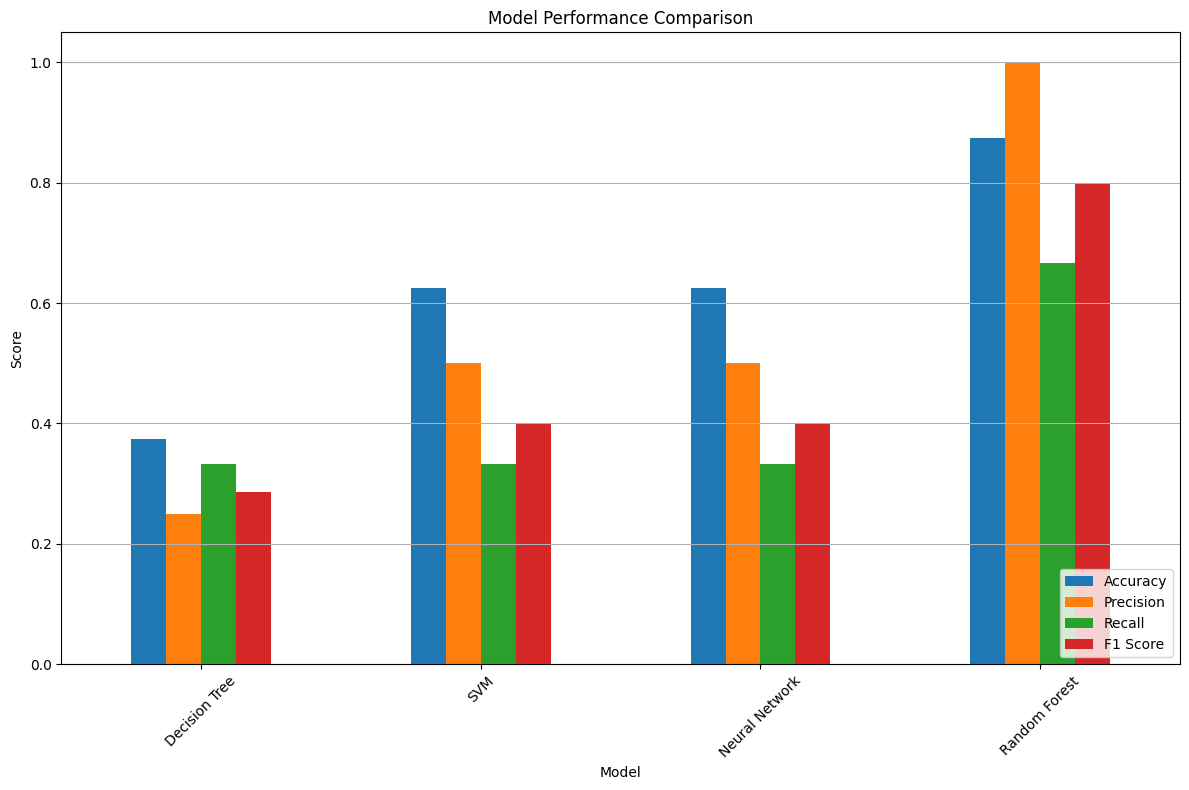

In [17]:
# Dictionary to store model results
model_results = {}

# 1. Decision Tree Classifier
print("Training Decision Tree Classifier...")
dt_params = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}
dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=5, scoring='f1')
dt_grid.fit(X_train_resampled, y_train_resampled)

dt_best = dt_grid.best_estimator_
y_pred_dt = dt_best.predict(X_test)
model_results['Decision Tree'] = {
    'accuracy': accuracy_score(y_test, y_pred_dt),
    'precision': precision_score(y_test, y_pred_dt),
    'recall': recall_score(y_test, y_pred_dt),
    'f1': f1_score(y_test, y_pred_dt),
    'best_params': dt_grid.best_params_
}

# 2. SVM Classifier
print("Training SVM Classifier...")
svm_params = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'linear']
}
svm_grid = GridSearchCV(SVC(probability=True, random_state=42), svm_params, cv=5, scoring='f1')
svm_grid.fit(X_train_resampled, y_train_resampled)

svm_best = svm_grid.best_estimator_
y_pred_svm = svm_best.predict(X_test)
model_results['SVM'] = {
    'accuracy': accuracy_score(y_test, y_pred_svm),
    'precision': precision_score(y_test, y_pred_svm),
    'recall': recall_score(y_test, y_pred_svm),
    'f1': f1_score(y_test, y_pred_svm),
    'best_params': svm_grid.best_params_
}

# 3. Neural Network Classifier
print("Training Neural Network Classifier...")
nn_params = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}
nn_grid = GridSearchCV(MLPClassifier(max_iter=1000, random_state=42), nn_params, cv=5, scoring='f1')
nn_grid.fit(X_train_resampled, y_train_resampled)

nn_best = nn_grid.best_estimator_
y_pred_nn = nn_best.predict(X_test)
model_results['Neural Network'] = {
    'accuracy': accuracy_score(y_test, y_pred_nn),
    'precision': precision_score(y_test, y_pred_nn),
    'recall': recall_score(y_test, y_pred_nn),
    'f1': f1_score(y_test, y_pred_nn),
    'best_params': nn_grid.best_params_
}

# 4. Random Forest Classifier
print("Training Random Forest Classifier...")
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'criterion': ['gini', 'entropy']
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='f1')
rf_grid.fit(X_train_resampled, y_train_resampled)

rf_best = rf_grid.best_estimator_
y_pred_rf = rf_best.predict(X_test)
model_results['Random Forest'] = {
    'accuracy': accuracy_score(y_test, y_pred_rf),
    'precision': precision_score(y_test, y_pred_rf),
    'recall': recall_score(y_test, y_pred_rf),
    'f1': f1_score(y_test, y_pred_rf),
    'best_params': rf_grid.best_params_
}

# Display model comparison results
results_df = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'])

for model_name, metrics in model_results.items():
    results_df.loc[model_name] = [
        metrics['accuracy'],
        metrics['precision'],
        metrics['recall'],
        metrics['f1']
    ]

print("\nModel Performance Comparison:")
print(results_df)

# Plot model comparison
plt.figure(figsize=(12, 8))
results_df.plot(kind='bar', figsize=(12, 8))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

######################################
# PART 9: MODEL EVALUATION
######################################


Best Model: Random Forest


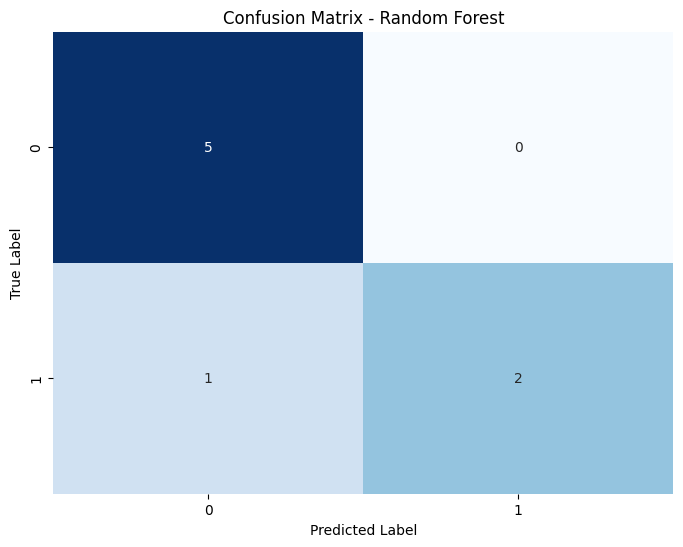

              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.67      0.80         3

    accuracy                           0.88         8
   macro avg       0.92      0.83      0.85         8
weighted avg       0.90      0.88      0.87         8



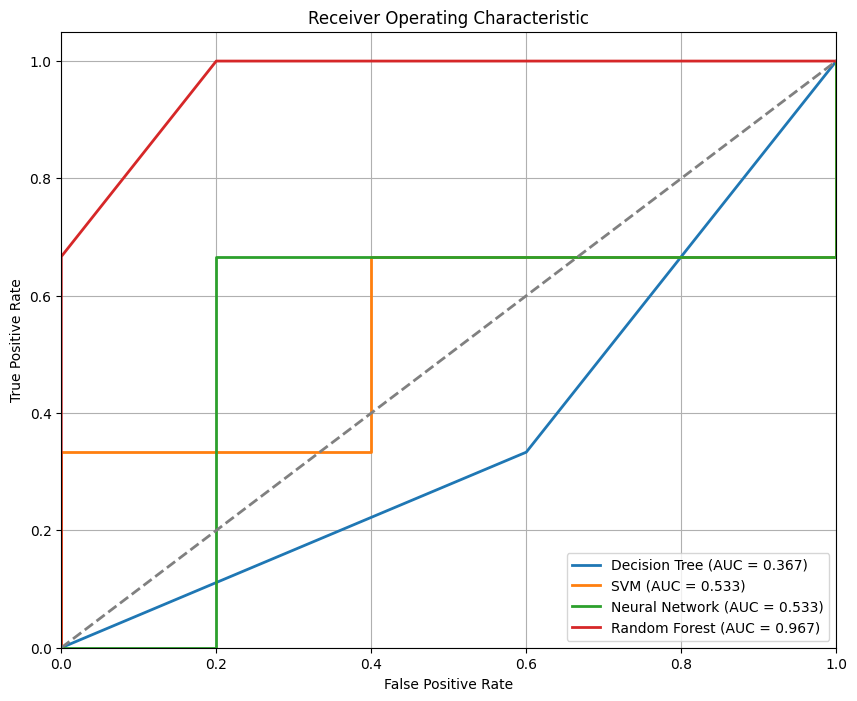

In [18]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    """
    Plot confusion matrix

    Args:
        y_true: True labels
        y_pred: Predicted labels
        title (str): Plot title
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Print classification report
    print(classification_report(y_true, y_pred))

# Plot confusion matrix for the best model
best_model_name = results_df['F1 Score'].idxmax()
print(f"\nBest Model: {best_model_name}")

if best_model_name == 'Decision Tree':
    best_model = dt_best
    y_pred_best = y_pred_dt
elif best_model_name == 'SVM':
    best_model = svm_best
    y_pred_best = y_pred_svm
elif best_model_name == 'Neural Network':
    best_model = nn_best
    y_pred_best = y_pred_nn
else:  # Random Forest
    best_model = rf_best
    y_pred_best = y_pred_rf

plot_confusion_matrix(y_test, y_pred_best, f'Confusion Matrix - {best_model_name}')

# Function to plot ROC curve
def plot_roc_curve(models, X_test, y_test):
    """
    Plot ROC curves for multiple models

    Args:
        models (dict): Dictionary of model objects
        X_test: Test features
        y_test: Test labels
    """
    plt.figure(figsize=(10, 8))

    for name, model in models.items():
        if hasattr(model, 'predict_proba'):
            y_prob = model.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# Plot ROC curves for all models
plot_roc_curve({
    'Decision Tree': dt_best,
    'SVM': svm_best,
    'Neural Network': nn_best,
    'Random Forest': rf_best
}, X_test, y_test)

########################################################################
# PART 10: FEATURE IMPORTANCE AND INTERPRETABILITY
########################################################################


Feature Importance Analysis (Random Forest):


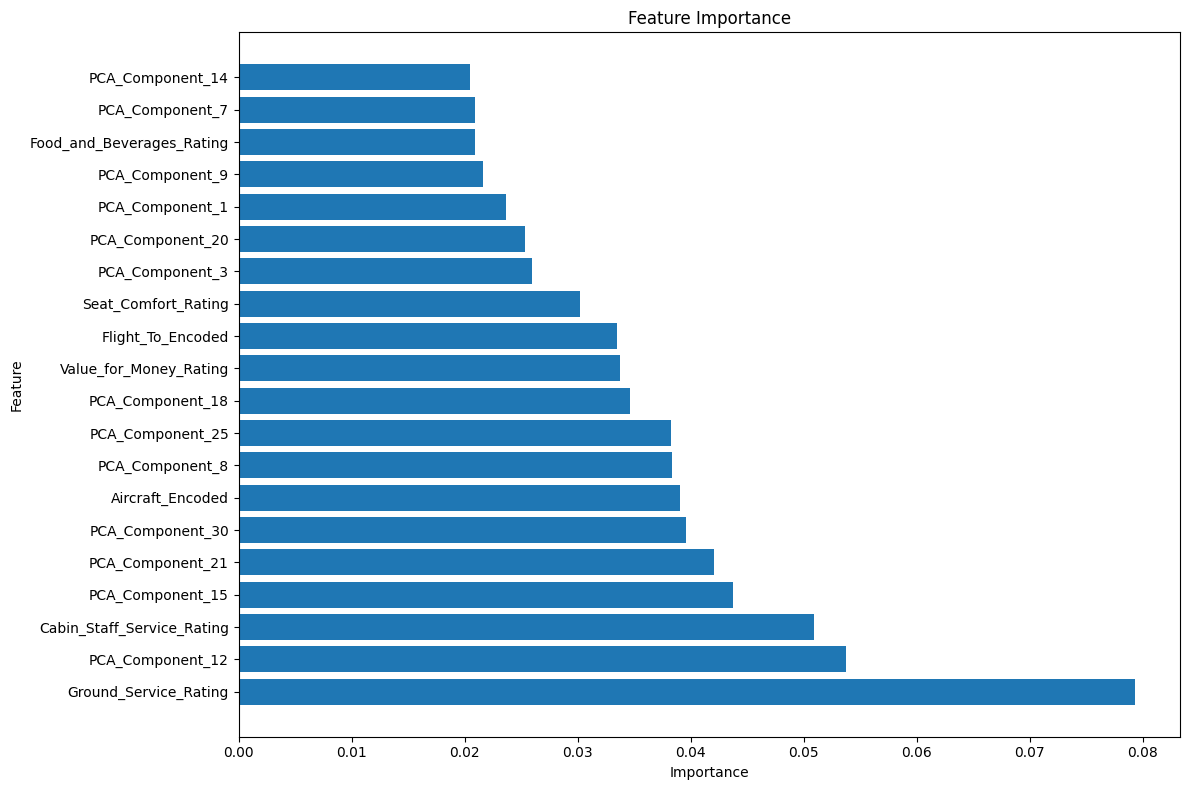


Feature Importance Analysis (Decision Tree):


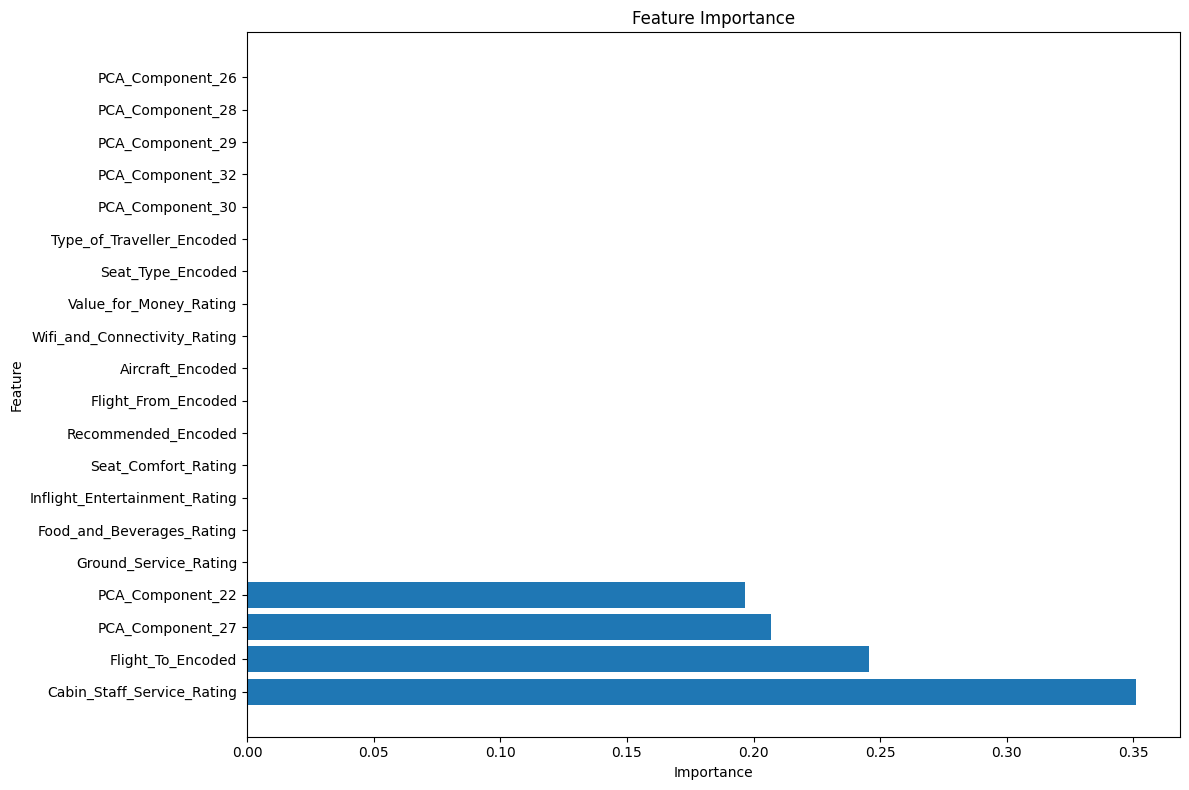

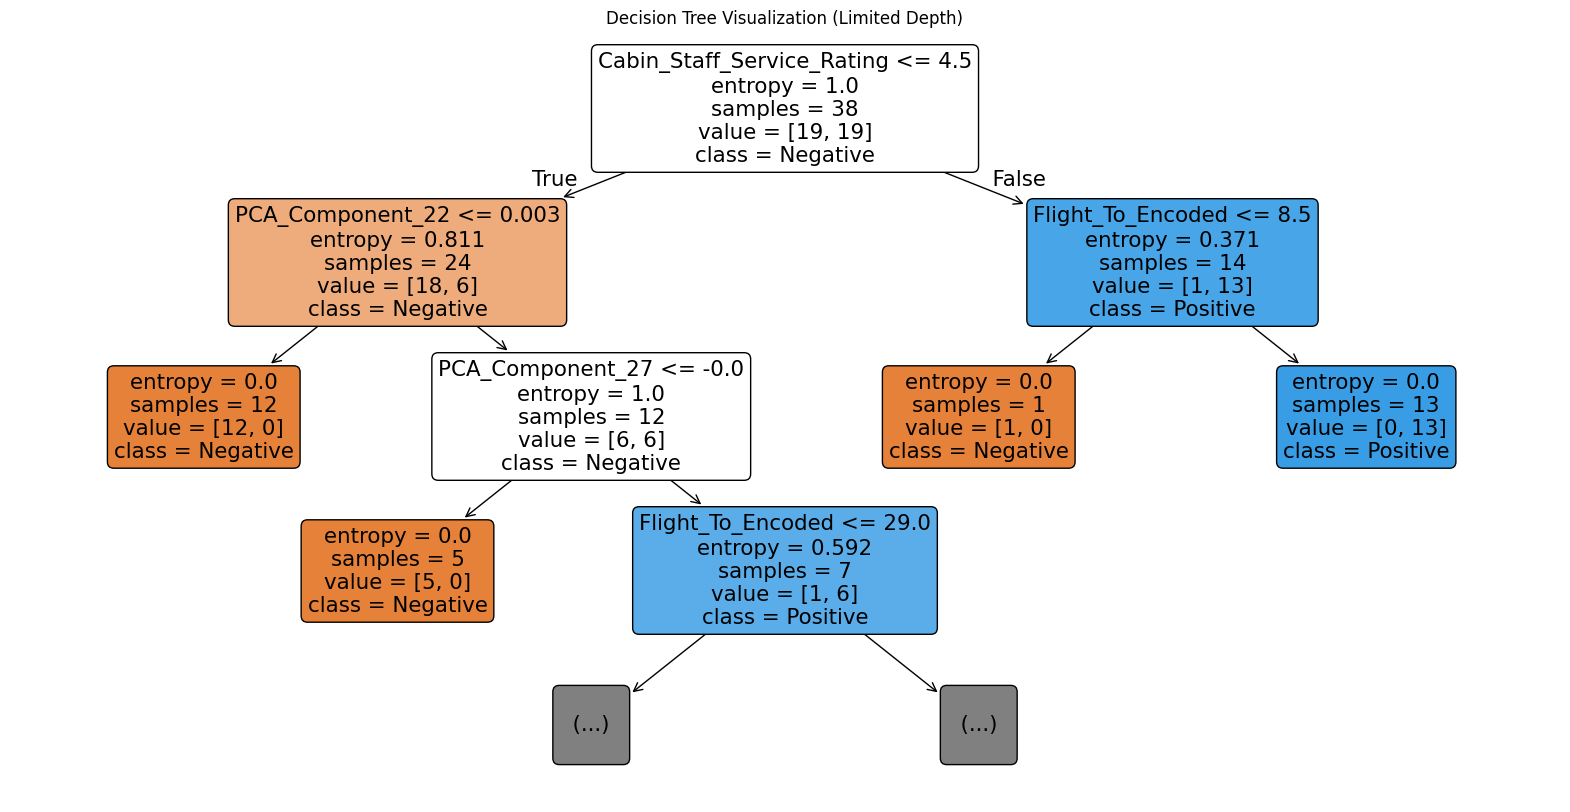

In [20]:
def plot_feature_importance_tree(model, feature_names, top_n=20):
    """
    Plot feature importance for tree-based models

    Args:
        model: Trained tree-based model
        feature_names (list): List of feature names
        top_n (int): Number of top features to display
    """
    # Get feature importance
    importances = model.feature_importances_

    # Create array of feature names and importances
    features_importance = np.array(list(zip(feature_names, importances)))

    # Sort by importance
    sorted_features_importance = features_importance[np.argsort(features_importance[:, 1].astype(float))[::-1]]

    # Select top features
    top_features = sorted_features_importance[:top_n]

    # Plot
    plt.figure(figsize=(12, 8))
    plt.barh(range(top_n), top_features[:, 1].astype(float))
    plt.yticks(range(top_n), top_features[:, 0])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()

    return sorted_features_importance

# Create a list of all feature names
all_feature_names = []

# Add TF-IDF feature names (reduced by PCA)
for i in range(n_components_95):
    all_feature_names.append(f'PCA_Component_{i+1}')

# Add categorical feature names
all_feature_names.extend(encoded_categorical_features)

# Add rating feature names
all_feature_names.extend(rating_features)

# Plot feature importance for the Random Forest model
if 'Random Forest' in model_results:
    print("\nFeature Importance Analysis (Random Forest):")
    sorted_features_rf = plot_feature_importance_tree(rf_best, all_feature_names)

# Plot feature importance for the Decision Tree model
if 'Decision Tree' in model_results:
    print("\nFeature Importance Analysis (Decision Tree):")
    sorted_features_dt = plot_feature_importance_tree(dt_best, all_feature_names)

    # Visualize the decision tree (limited depth for clarity)
    plt.figure(figsize=(20, 10))
    plot_tree(dt_best, max_depth=3, feature_names=all_feature_names,
              filled=True, rounded=True, class_names=['Negative', 'Positive'])
    plt.title('Decision Tree Visualization (Limited Depth)')
    plt.show()

######################################################
# PART 11: LEARNING TO RANK FEATURES
######################################################


Training XGBoost Ranker...


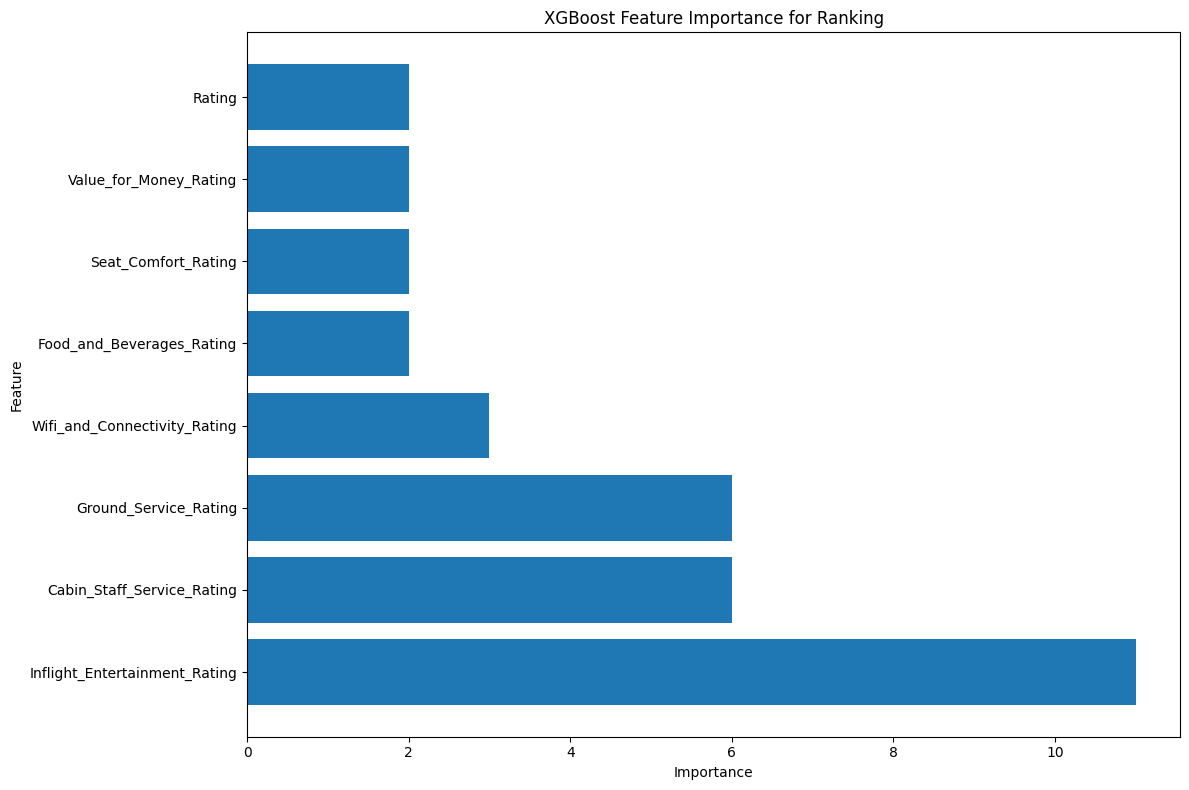

In [21]:
# Prepare data for learning to rank
def prepare_ranking_data(df, feature_cols):
    """
    Prepare data for learning to rank algorithms

    Args:
        df (pandas.DataFrame): Input dataframe
        feature_cols (list): List of feature columns

    Returns:
        tuple: (X, y, qids) where X is features, y is labels, and qids are query IDs
    """
    # Fill NaN values
    df_ranking = df[feature_cols].copy()
    df_ranking = df_ranking.fillna(df_ranking.mean())

    # Get features and target
    X = df_ranking.values
    y = df['Sentiment_Score'].values

    # Create query IDs (group by Seat_Type)
    if 'Seat_Type' in df.columns:
        qids = df['Seat_Type'].fillna('Unknown').astype('category').cat.codes.values
    else:
        qids = np.zeros(len(df))

    return X, y, qids

# Select features for ranking
ranking_features = rating_features + ['Rating']

# Filter valid records for ranking
df_ranking = df[~df[ranking_features].isnull().all(axis=1)].copy()
df_ranking['Rating'] = pd.to_numeric(df_ranking['Rating'], errors='coerce')
df_ranking = df_ranking.dropna(subset=['Rating'])

# Prepare data for learning to rank
X_rank, y_rank, qids = prepare_ranking_data(df_ranking, ranking_features)

# Split the ranking data
X_rank_train, X_rank_test, y_rank_train, y_rank_test, qids_train, qids_test = train_test_split(
    X_rank, y_rank, qids, test_size=0.2, random_state=42
)

# Train XGBoost Ranker
def train_xgboost_ranker(X_train, y_train, qids_train):
    """
    Train XGBoost Ranking model

    Args:
        X_train: Training features
        y_train: Training labels
        qids_train: Training query IDs

    Returns:
        xgboost.Booster: Trained XGBoost model
    """
    # Convert labels to ranks within each group
    group_data = {}
    for i, qid in enumerate(qids_train):
        if qid not in group_data:
            group_data[qid] = []
        group_data[qid].append((X_train[i], y_train[i]))

    # Sort by score within each group
    for qid in group_data:
        group_data[qid].sort(key=lambda x: x[1], reverse=True)

    # Create DMatrix with group information
    X_train_rank = []
    y_train_rank = []
    group_sizes = []

    for qid in sorted(group_data.keys()):
        group = group_data[qid]
        group_X = np.array([item[0] for item in group])
        group_y = np.array([item[1] for item in group])

        X_train_rank.append(group_X)
        y_train_rank.append(group_y)
        group_sizes.append(len(group))

    X_train_rank = np.vstack(X_train_rank)
    y_train_rank = np.concatenate(y_train_rank)

    # Create DMatrix
    dtrain = xgb.DMatrix(X_train_rank, label=y_train_rank)
    dtrain.set_group(group_sizes)

    # Set parameters
    params = {
        'objective': 'rank:pairwise',
        'eta': 0.1,
        'gamma': 1.0,
        'min_child_weight': 0.1,
        'max_depth': 6
    }

    # Train model
    model = xgb.train(params, dtrain, num_boost_round=100)

    return model

# Train XGBoost Ranker
print("\nTraining XGBoost Ranker...")
xgb_ranker = train_xgboost_ranker(X_rank_train, y_rank_train, qids_train)

# Get feature importance from XGBoost Ranker
def plot_xgb_feature_importance(model, feature_names):
    """
    Plot feature importance from XGBoost model

    Args:
        model: Trained XGBoost model
        feature_names (list): List of feature names
    """
    importance_scores = model.get_score(importance_type='weight')
    importance_frame = pd.DataFrame({
        'Feature': list(importance_scores.keys()),
        'Importance': list(importance_scores.values())
    })
    importance_frame = importance_frame.sort_values('Importance', ascending=False)

    # Map feature indices to names
    importance_frame['Feature_Name'] = importance_frame['Feature'].apply(
        lambda x: feature_names[int(x.replace('f', ''))] if x.replace('f', '').isdigit() else x
    )

    # Plot
    plt.figure(figsize=(12, 8))
    plt.barh(importance_frame['Feature_Name'], importance_frame['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('XGBoost Feature Importance for Ranking')
    plt.tight_layout()
    plt.show()

    return importance_frame

# Plot XGBoost feature importance
ranking_feature_importance = plot_xgb_feature_importance(xgb_ranker, ranking_features)

#########################################
# PART 12: ADVANCED ANALYSIS
#########################################

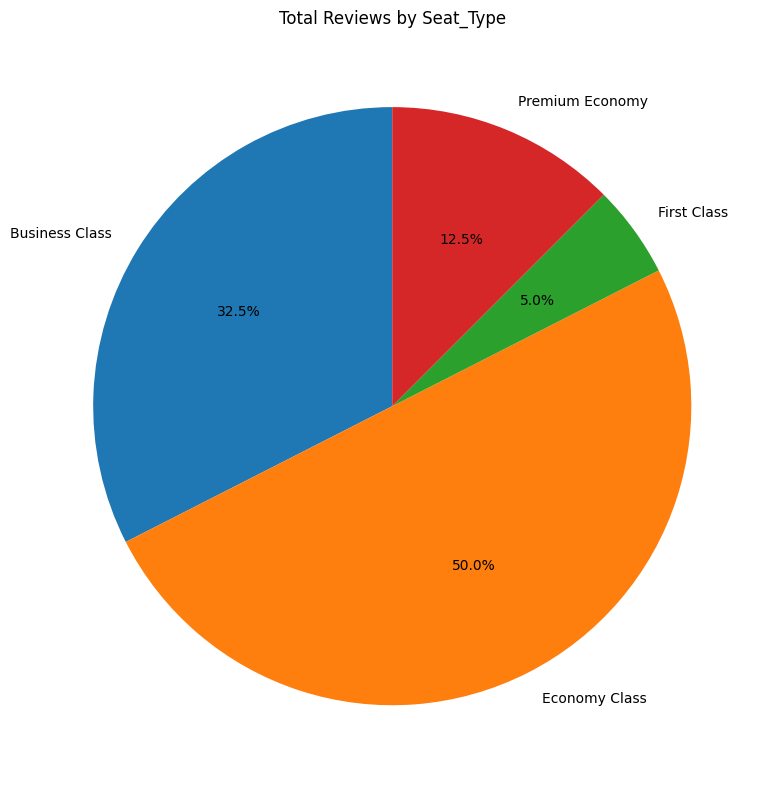

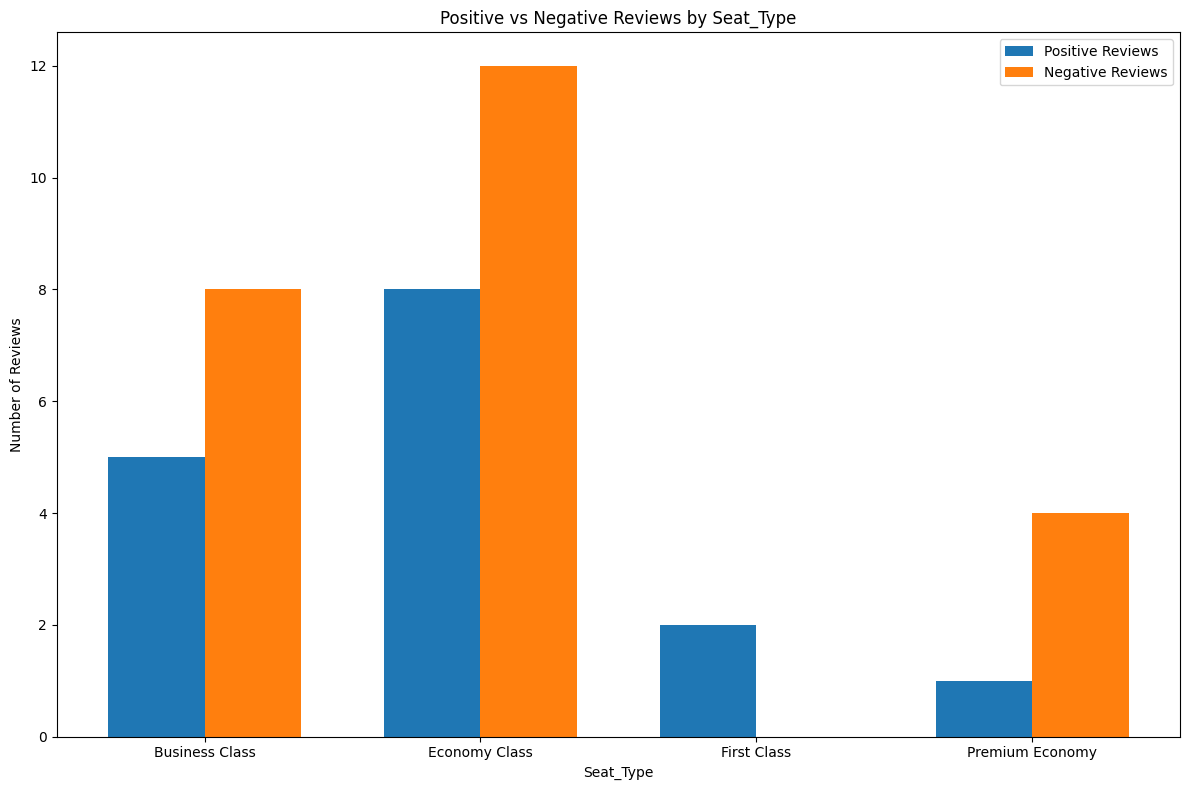

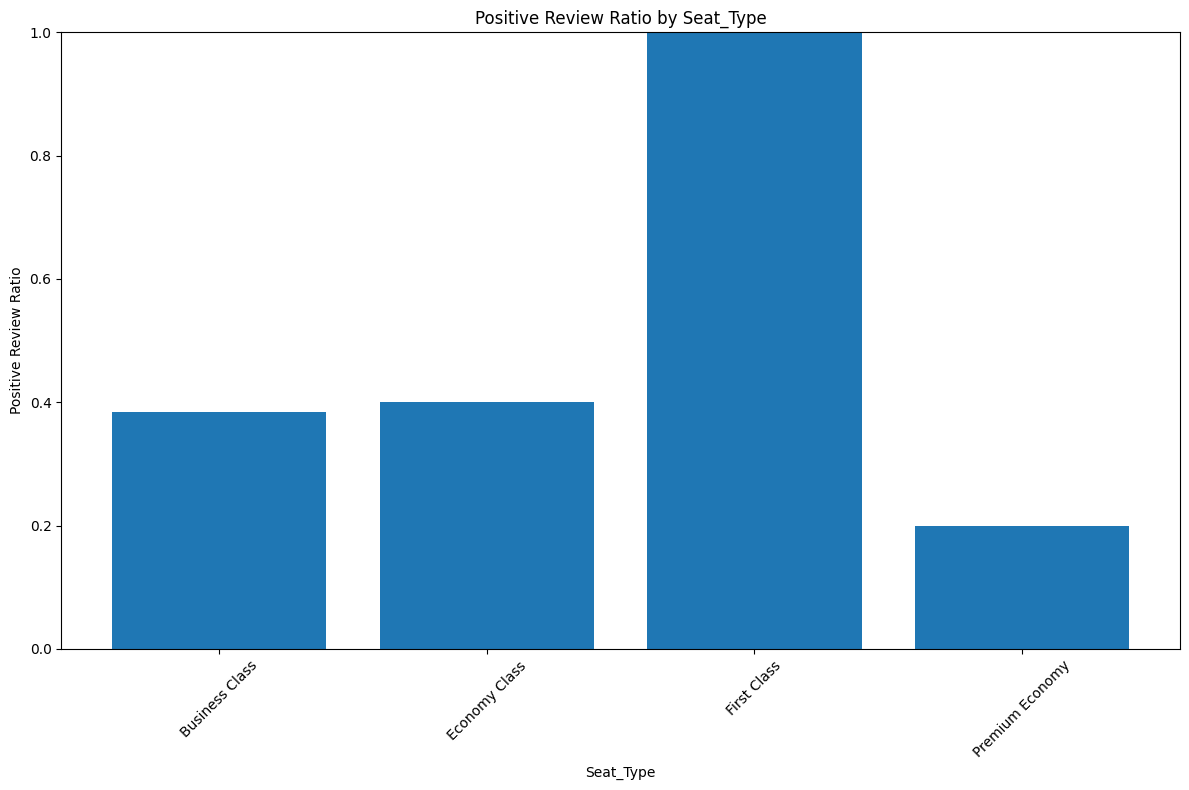


Sentiment Analysis by Seat Type:
         Seat_Type  Negative Reviews  Positive Reviews  Total  Positive Ratio  \
0   Business Class                 8                 5     13        0.384615   
1    Economy Class                12                 8     20        0.400000   
2      First Class                 0                 2      2        1.000000   
3  Premium Economy                 4                 1      5        0.200000   

   Negative Ratio  
0        0.615385  
1        0.600000  
2        0.000000  
3        0.800000  


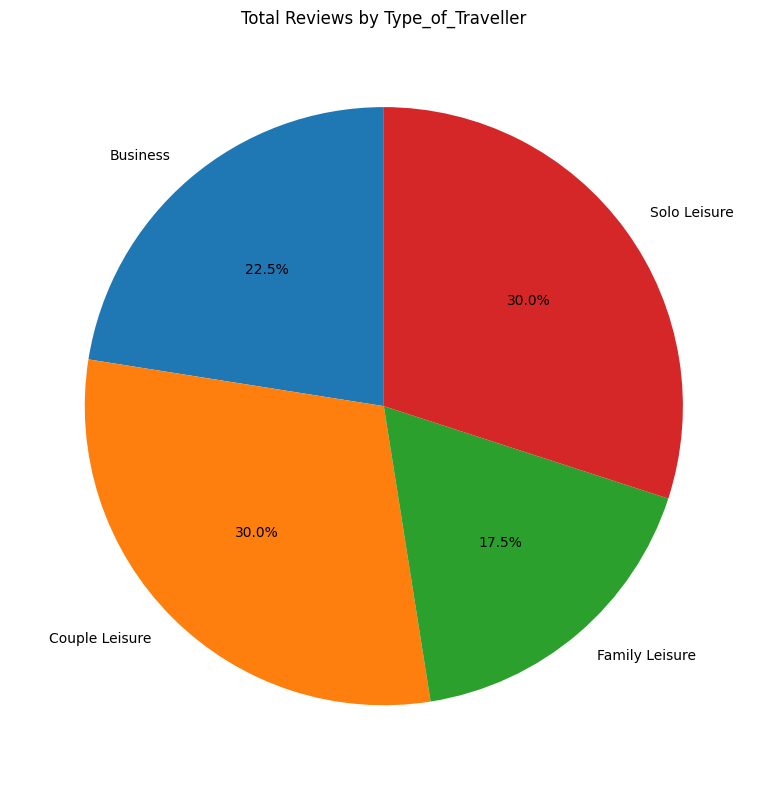

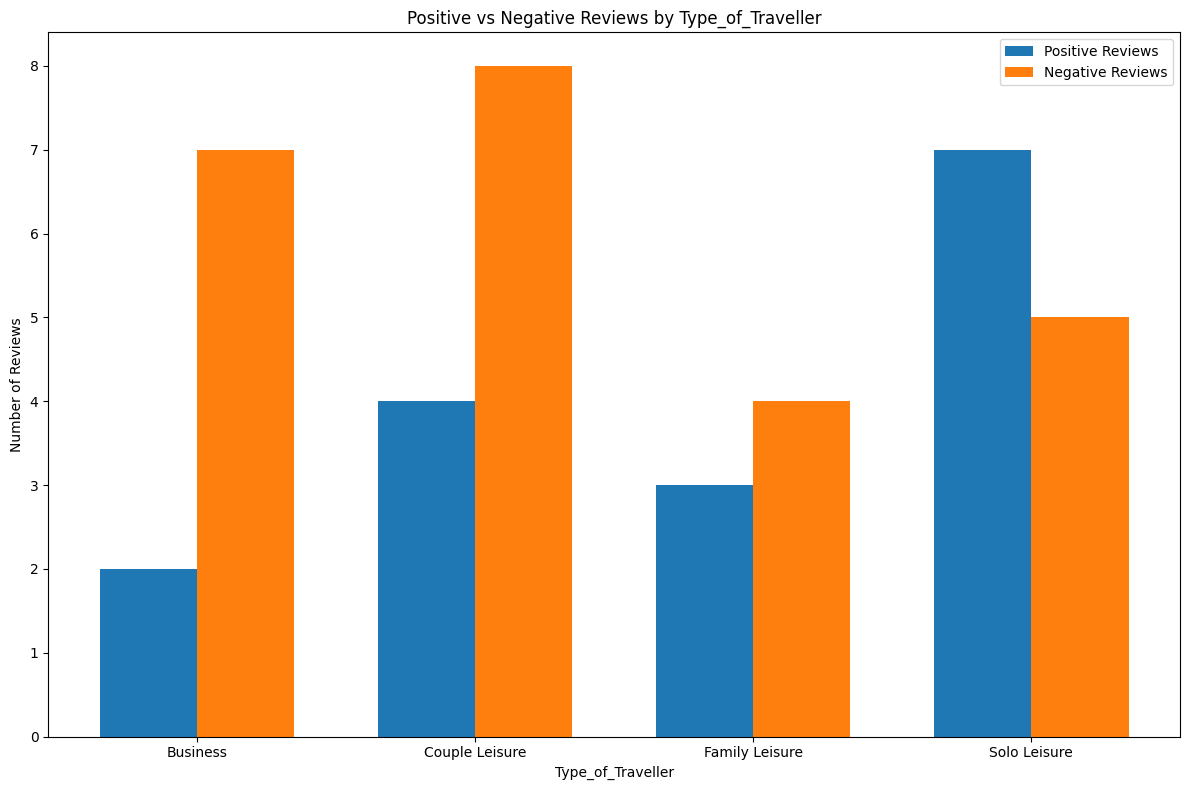

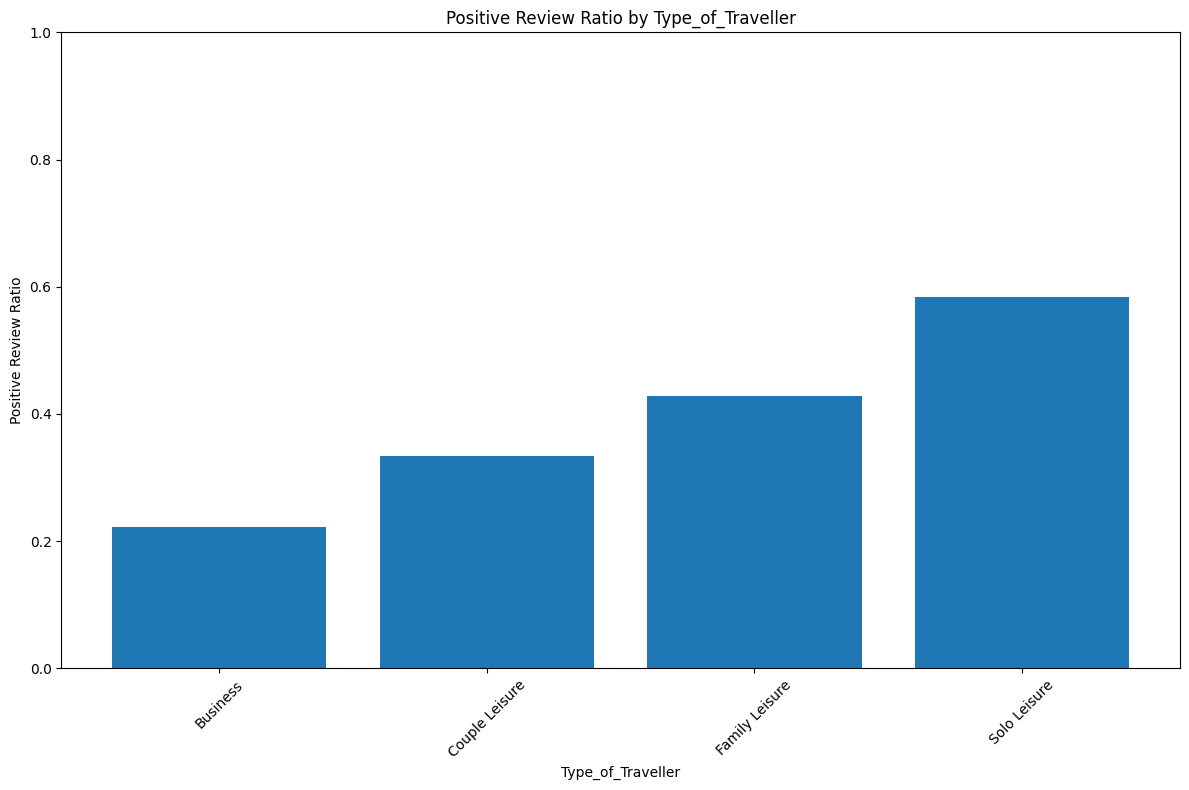


Sentiment Analysis by Traveler Type:
  Type_of_Traveller  Negative Reviews  Positive Reviews  Total  \
0          Business                 7                 2      9   
1    Couple Leisure                 8                 4     12   
2    Family Leisure                 4                 3      7   
3      Solo Leisure                 5                 7     12   

   Positive Ratio  Negative Ratio  
0        0.222222        0.777778  
1        0.333333        0.666667  
2        0.428571        0.571429  
3        0.583333        0.416667  


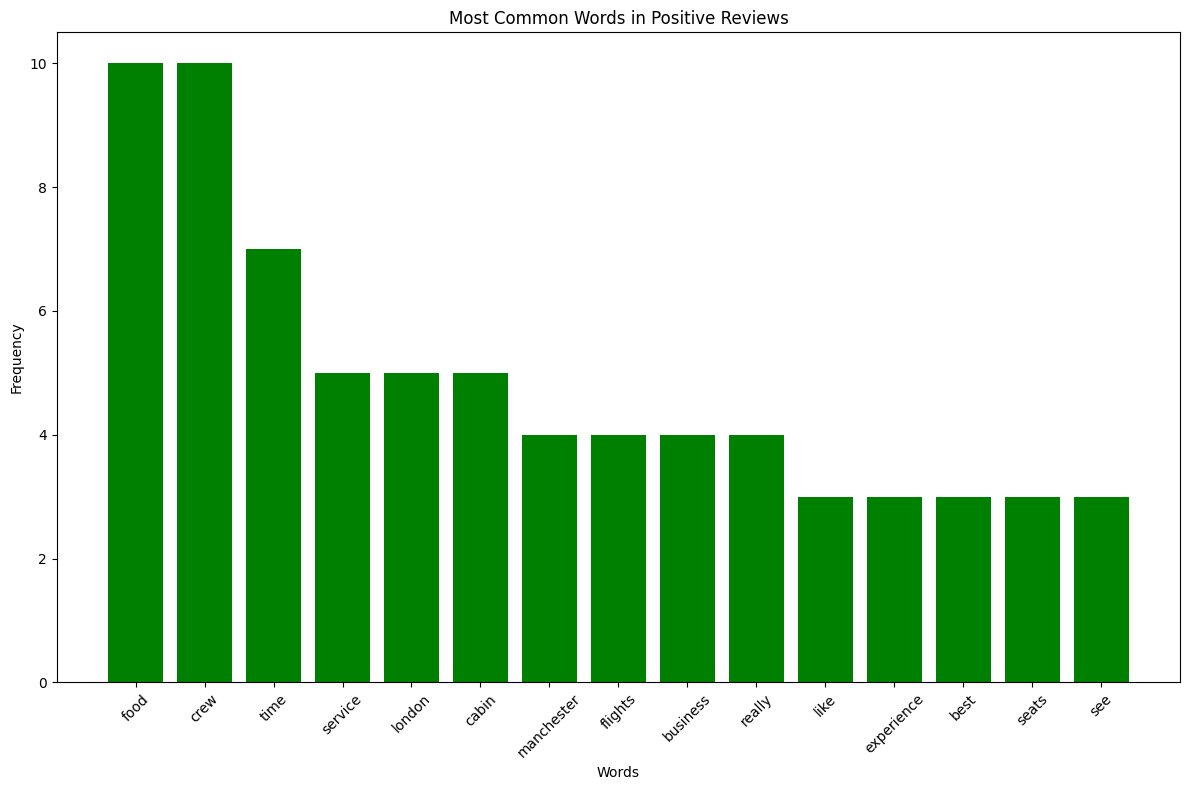

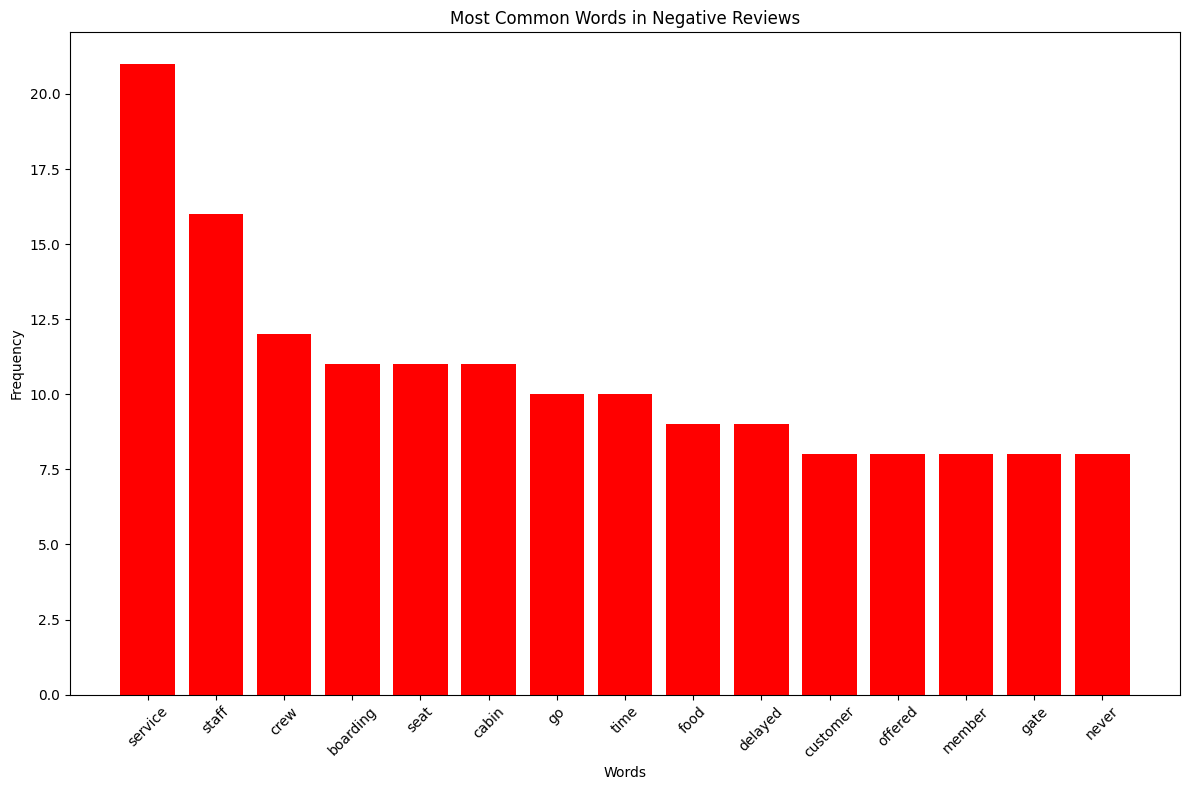

In [22]:
# Analyze sentiment by seat type
def analyze_sentiment_by_category(df, category_col):
    """
    Analyze sentiment by category

    Args:
        df (pandas.DataFrame): Input dataframe
        category_col (str): Category column name
    """
    # Count by category
    category_counts = df.groupby(category_col)[category_col].count().reset_index(name='Total Reviews')

    # Plot pie chart
    plt.figure(figsize=(12, 8))
    plt.pie(category_counts['Total Reviews'], labels=category_counts[category_col],
            autopct='%1.1f%%', startangle=90)
    plt.title(f'Total Reviews by {category_col}')
    plt.tight_layout()
    plt.show()

    # Calculate positive and negative reviews by category
    neg_reviews = df.groupby(category_col)['Sentiment_Score'].apply(
        lambda x: (x < 0).sum()).reset_index(name='Negative Reviews')
    pos_reviews = df.groupby(category_col)['Sentiment_Score'].apply(
        lambda x: (x > 0).sum()).reset_index(name='Positive Reviews')

    # Merge results
    category_sentiment = pd.merge(neg_reviews, pos_reviews, on=category_col)
    category_sentiment['Total'] = category_sentiment['Negative Reviews'] + category_sentiment['Positive Reviews']
    category_sentiment['Positive Ratio'] = category_sentiment['Positive Reviews'] / category_sentiment['Total']
    category_sentiment['Negative Ratio'] = category_sentiment['Negative Reviews'] / category_sentiment['Total']

    # Plot bar chart
    x = np.arange(len(category_sentiment[category_col]))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.bar(x - width/2, category_sentiment['Positive Reviews'], width, label='Positive Reviews')
    ax.bar(x + width/2, category_sentiment['Negative Reviews'], width, label='Negative Reviews')

    ax.set_xticks(x)
    ax.set_xticklabels(category_sentiment[category_col])
    ax.legend()
    ax.set_title(f'Positive vs Negative Reviews by {category_col}')
    ax.set_xlabel(category_col)
    ax.set_ylabel('Number of Reviews')

    plt.tight_layout()
    plt.show()

    # Plot positive ratio
    plt.figure(figsize=(12, 8))
    plt.bar(category_sentiment[category_col], category_sentiment['Positive Ratio'])
    plt.title(f'Positive Review Ratio by {category_col}')
    plt.xlabel(category_col)
    plt.ylabel('Positive Review Ratio')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return category_sentiment

# Analyze sentiment by seat type
seat_type_analysis = analyze_sentiment_by_category(df.dropna(subset=['Seat_Type']), 'Seat_Type')
print("\nSentiment Analysis by Seat Type:")
print(seat_type_analysis)

# Analyze sentiment by traveler type
traveler_type_analysis = analyze_sentiment_by_category(df.dropna(subset=['Type_of_Traveller']), 'Type_of_Traveller')
print("\nSentiment Analysis by Traveler Type:")
print(traveler_type_analysis)

# Analyze common words in positive and negative reviews
def analyze_common_words(df):
    """
    Analyze common words in positive and negative reviews

    Args:
        df (pandas.DataFrame): Input dataframe
    """
    # Get positive and negative reviews
    pos_reviews = df.loc[df['Sentiment_Score'] > 0, 'Filtered_Review']
    neg_reviews = df.loc[df['Sentiment_Score'] < 0, 'Filtered_Review']

    # Count word frequencies
    pos_word_counts = Counter(" ".join(pos_reviews).split())
    neg_word_counts = Counter(" ".join(neg_reviews).split())

    # Get most common words
    pos_common = pos_word_counts.most_common(15)
    neg_common = neg_word_counts.most_common(15)

    # Extract words and counts
    pos_words = [word for word, count in pos_common]
    pos_counts = [count for word, count in pos_common]

    neg_words = [word for word, count in neg_common]
    neg_counts = [count for word, count in neg_common]

    # Plot for positive words
    plt.figure(figsize=(12, 8))
    plt.bar(pos_words, pos_counts, color='green')
    plt.title('Most Common Words in Positive Reviews')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot for negative words
    plt.figure(figsize=(12, 8))
    plt.bar(neg_words, neg_counts, color='red')
    plt.title('Most Common Words in Negative Reviews')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Analyze common words in positive and negative reviews
analyze_common_words(df)

#################################################
# PART 13: RATING FEATURE ANALYSIS
#################################################

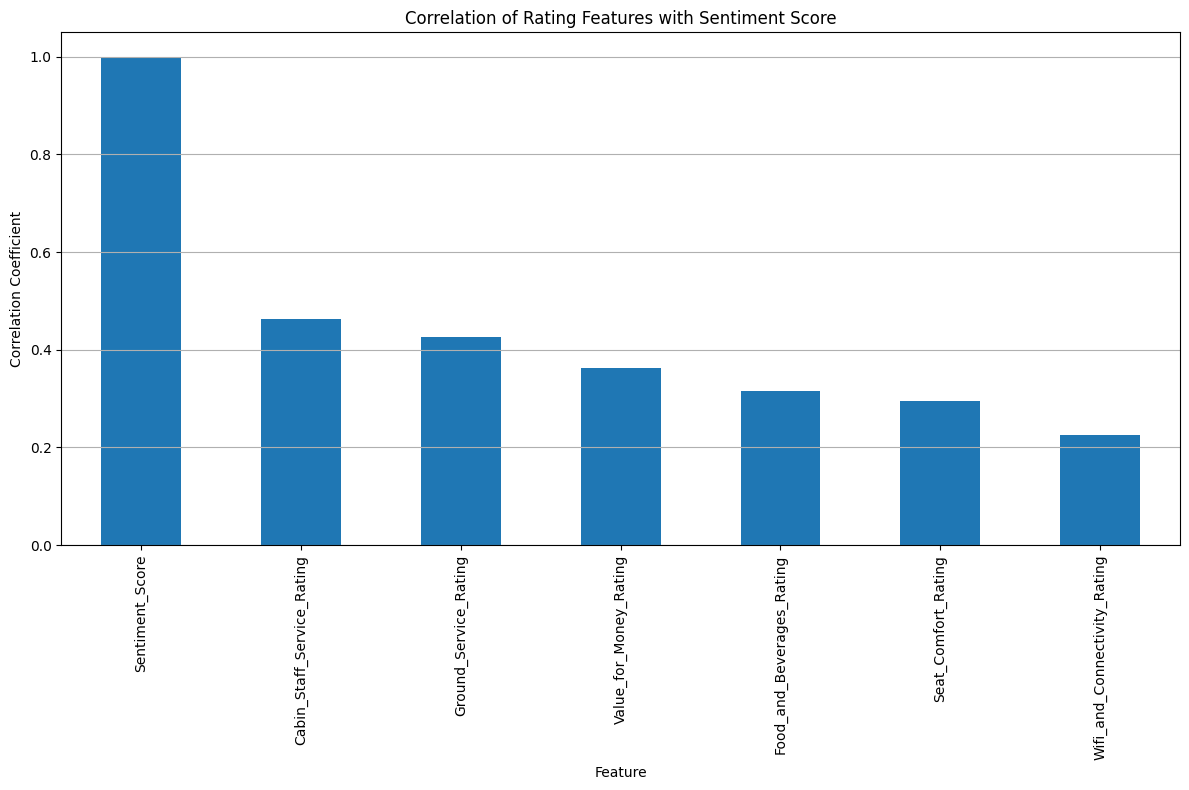

<Figure size 1400x800 with 0 Axes>

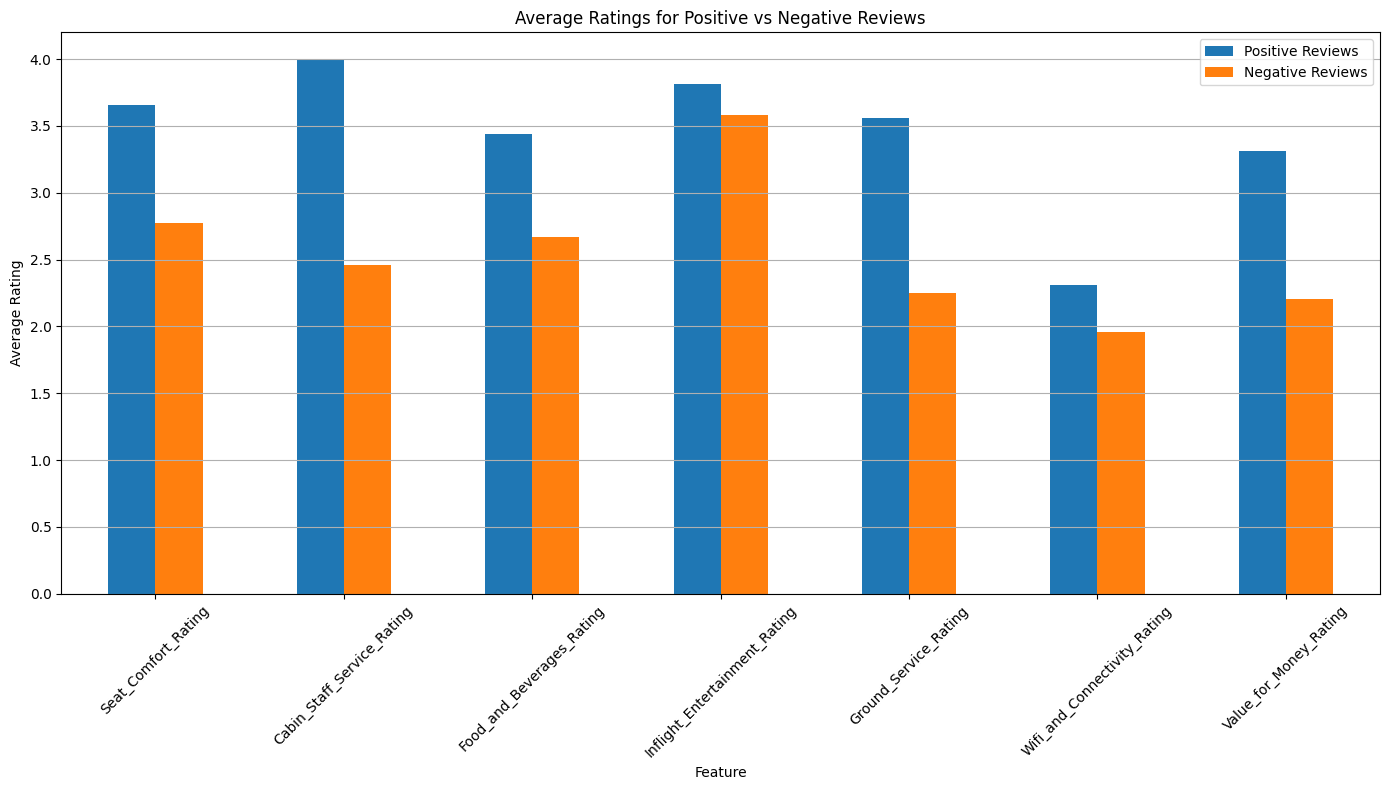


Rating Feature Correlations with Sentiment:
Sentiment_Score                  1.000000
Cabin_Staff_Service_Rating       0.462265
Ground_Service_Rating            0.426357
Value_for_Money_Rating           0.362436
Food_and_Beverages_Rating        0.316413
Seat_Comfort_Rating              0.296040
Wifi_and_Connectivity_Rating     0.225885
Inflight_Entertainment_Rating    0.103820
Name: Sentiment_Score, dtype: float64


In [23]:
# Analyze the influence of rating features on sentiment
def analyze_rating_features(df, rating_features):
    """
    Analyze rating features and their influence on sentiment

    Args:
        df (pandas.DataFrame): Input dataframe
        rating_features (list): List of rating feature names
    """
    # Create a copy of the dataframe with only relevant columns
    df_ratings = df[rating_features + ['Sentiment_Score']].copy()

    # Fill NaN values with median
    for col in rating_features:
        df_ratings[col] = df_ratings[col].fillna(df_ratings[col].median())

    # Calculate correlation with sentiment
    correlations = df_ratings.corr()['Sentiment_Score'].sort_values(ascending=False)

    # Plot correlation
    plt.figure(figsize=(12, 8))
    correlations[:-1].plot(kind='bar')  # Exclude correlation with itself
    plt.title('Correlation of Rating Features with Sentiment Score')
    plt.xlabel('Feature')
    plt.ylabel('Correlation Coefficient')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    # Calculate average ratings for positive and negative sentiments
    avg_ratings_pos = df_ratings[df_ratings['Sentiment_Score'] > 0][rating_features].mean()
    avg_ratings_neg = df_ratings[df_ratings['Sentiment_Score'] < 0][rating_features].mean()

    # Create a DataFrame for comparison
    avg_ratings = pd.DataFrame({
        'Positive Reviews': avg_ratings_pos,
        'Negative Reviews': avg_ratings_neg
    })

    # Plot average ratings
    plt.figure(figsize=(14, 8))
    avg_ratings.plot(kind='bar', figsize=(14, 8))
    plt.title('Average Ratings for Positive vs Negative Reviews')
    plt.xlabel('Feature')
    plt.ylabel('Average Rating')
    plt.grid(axis='y')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return correlations, avg_ratings

# Analyze rating features
rating_correlations, avg_ratings = analyze_rating_features(df, rating_features)
print("\nRating Feature Correlations with Sentiment:")
print(rating_correlations)

###########################################################################
# PART 14: SHAP ANALYSIS FOR MODEL INTERPRETABILITY
###########################################################################


SHAP Analysis for Random Forest:


<Figure size 1200x800 with 0 Axes>

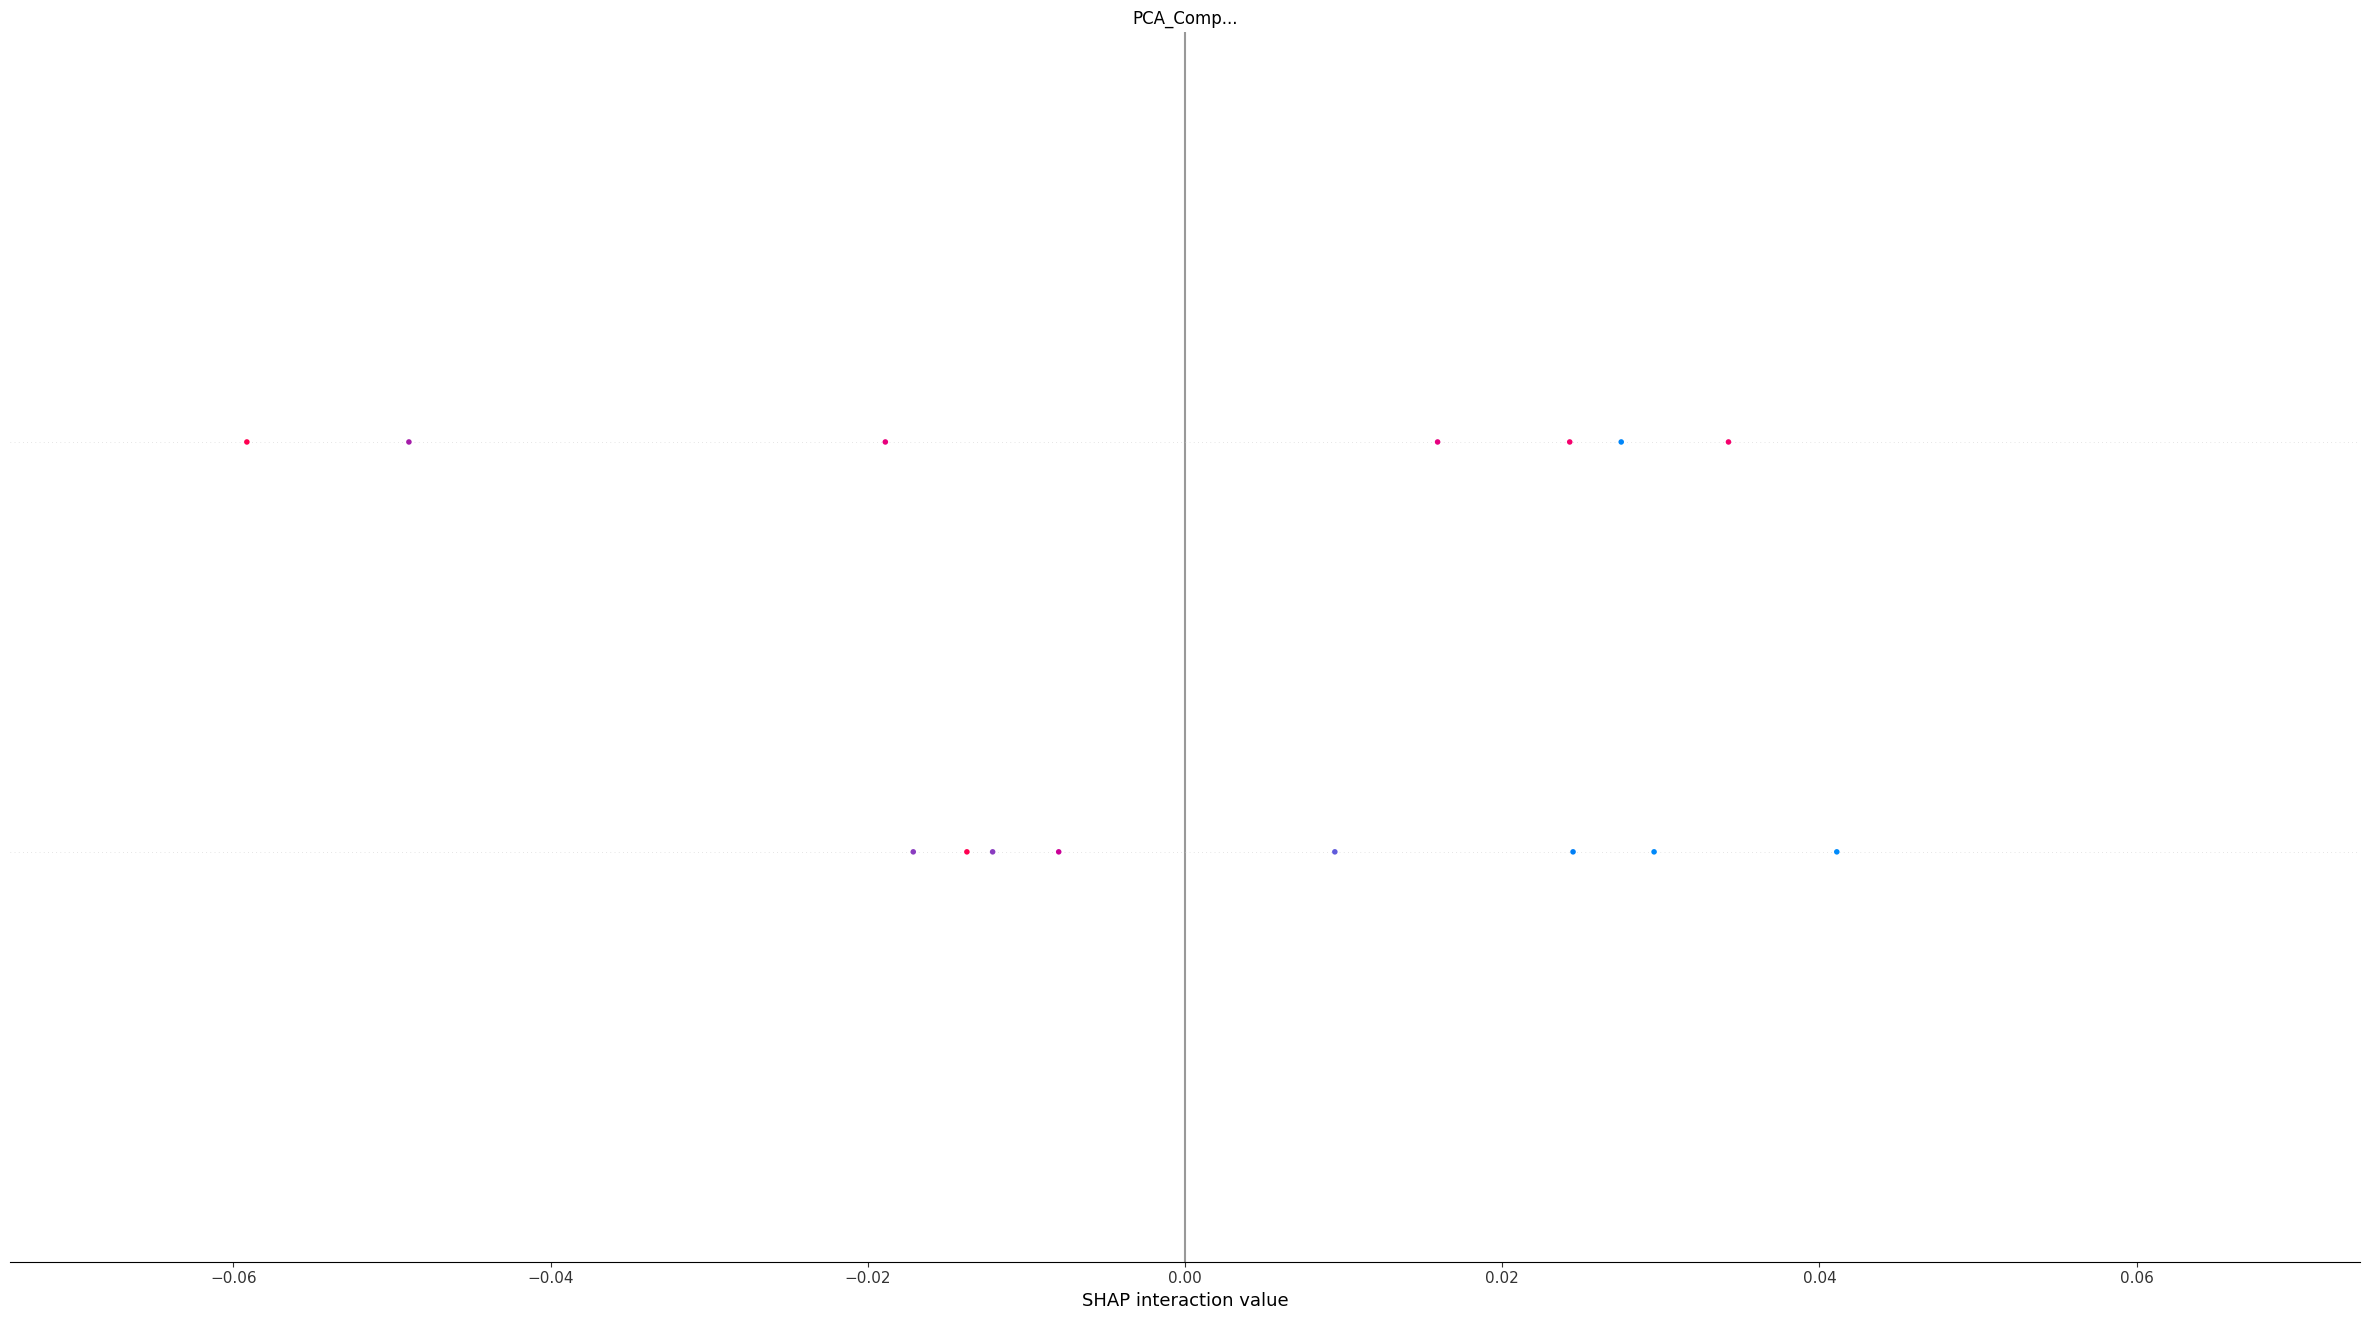

<Figure size 640x480 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

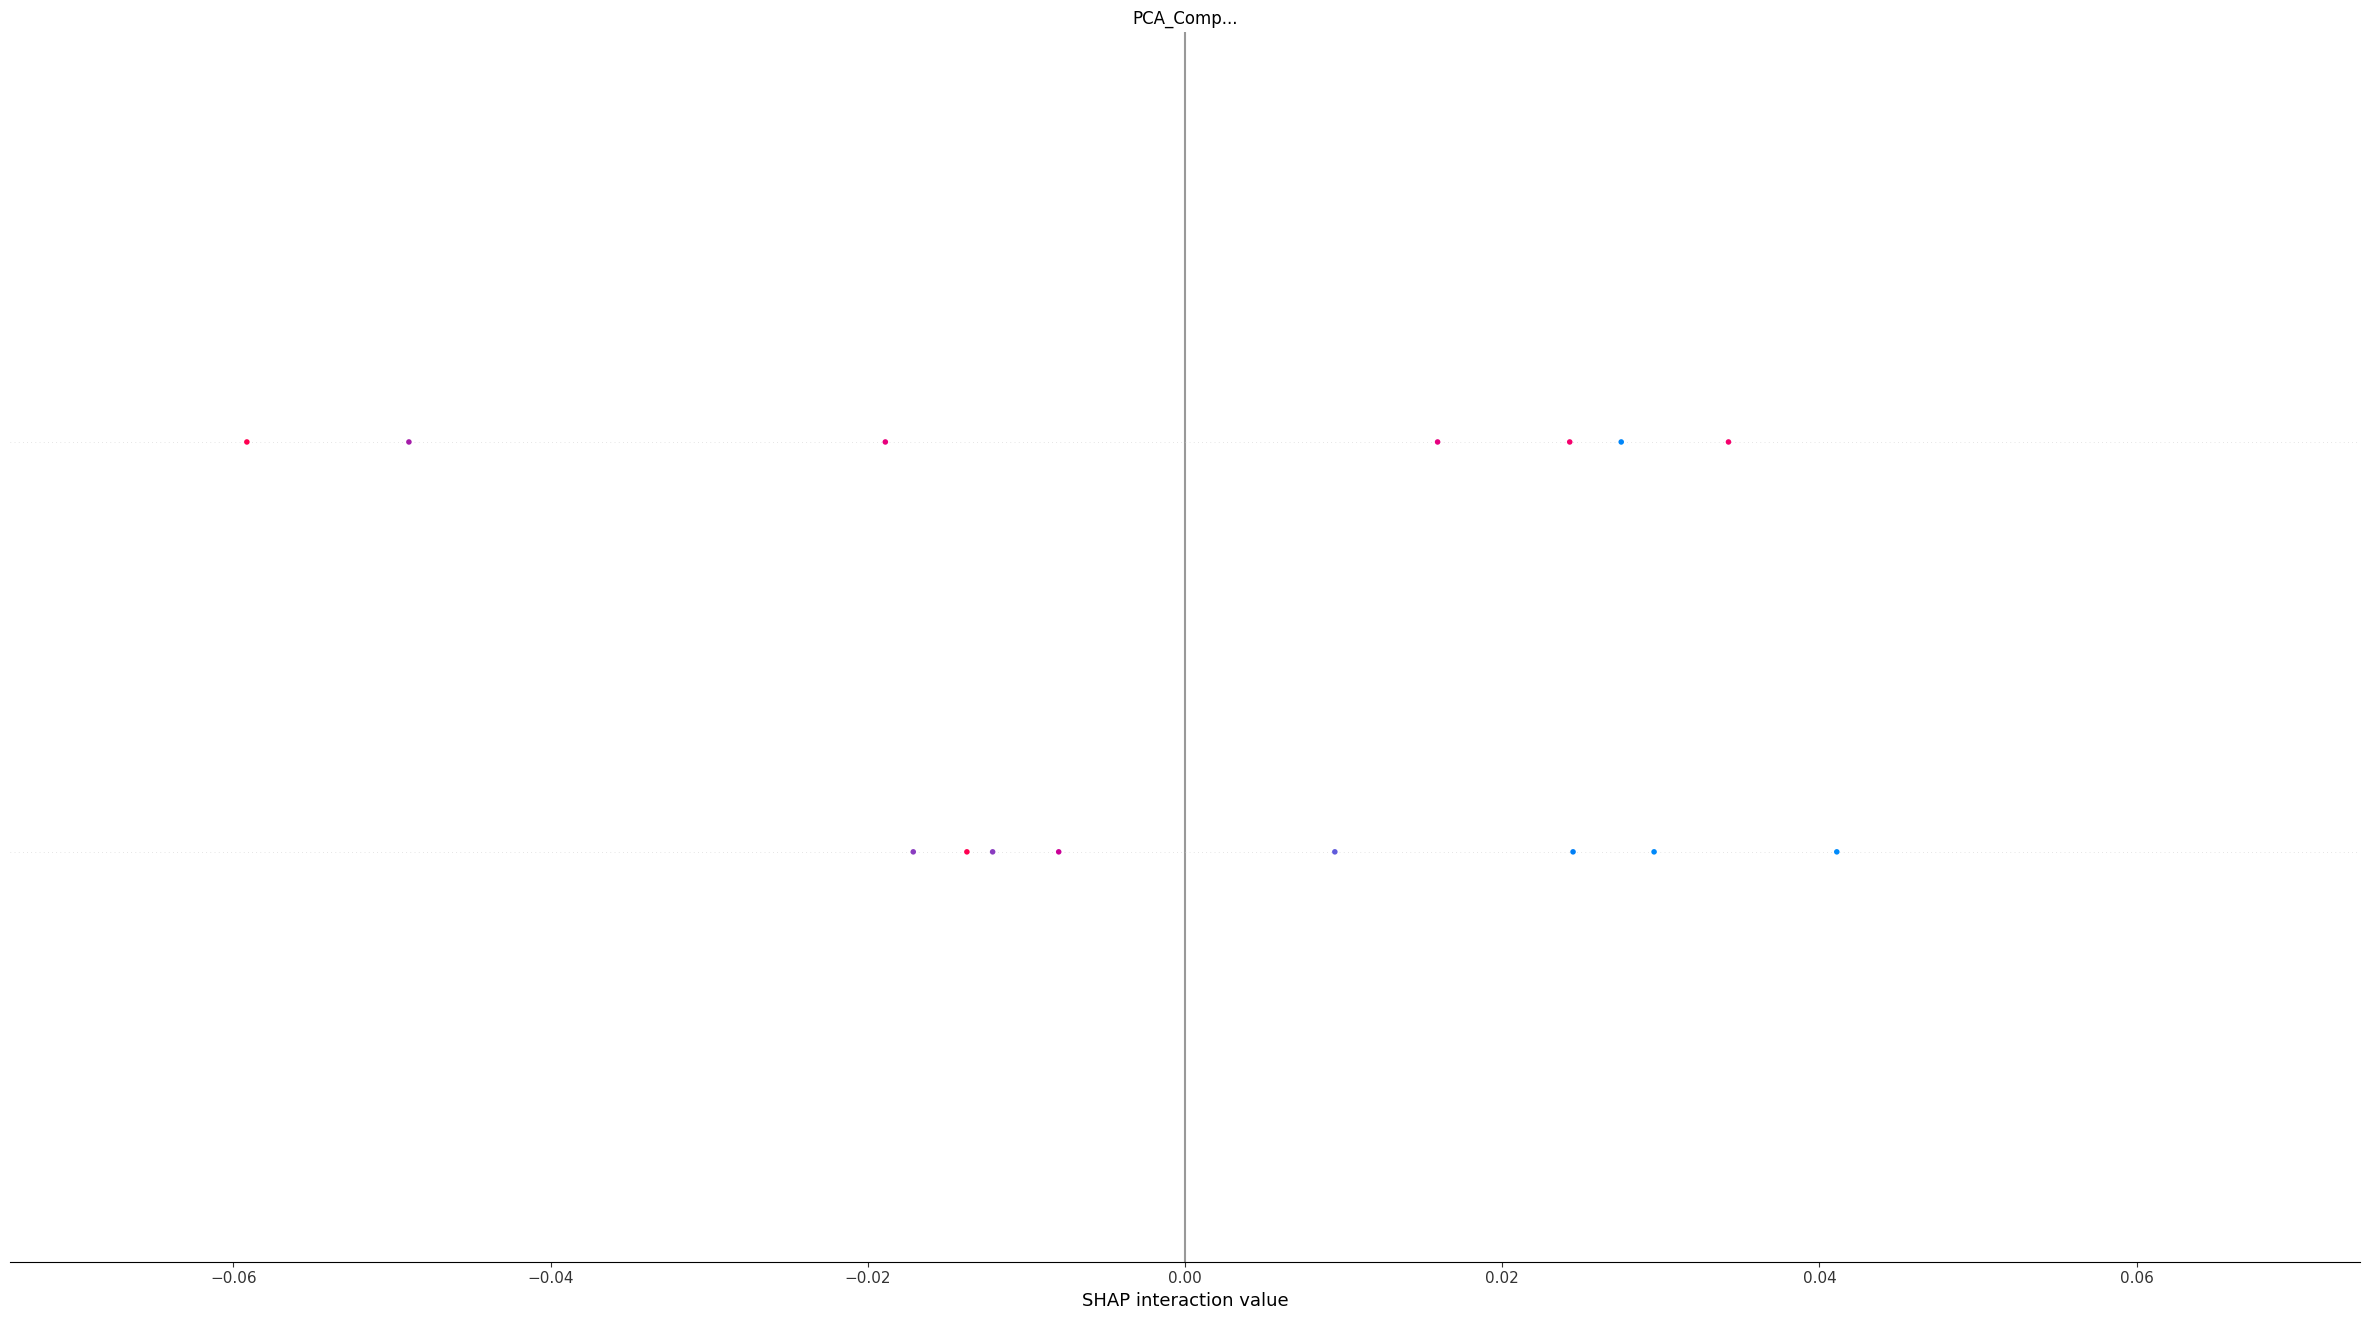

<Figure size 640x480 with 0 Axes>

In [24]:
def analyze_shap_values(model, X_test, feature_names, max_display=20):
    """
    Analyze SHAP values for model interpretability

    Args:
        model: Trained model
        X_test: Test features
        feature_names (list): List of feature names
        max_display (int): Maximum number of features to display
    """
    # Create a SHAP explainer
    if isinstance(model, (RandomForestClassifier, DecisionTreeClassifier)):
        explainer = shap.TreeExplainer(model)
    elif isinstance(model, SVC):
        explainer = shap.KernelExplainer(model.predict, shap.sample(X_test, 100))
    elif isinstance(model, MLPClassifier):
        explainer = shap.KernelExplainer(model.predict, shap.sample(X_test, 100))
    else:
        print("Model type not supported for SHAP analysis")
        return

    # Calculate SHAP values
    shap_values = explainer.shap_values(X_test)

    # Plot summary
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test, feature_names=feature_names, max_display=max_display)
    plt.tight_layout()
    plt.show()

    # Plot bar summary
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type='bar', max_display=max_display)
    plt.tight_layout()
    plt.show()

# Analyze SHAP values for the best model
print(f"\nSHAP Analysis for {best_model_name}:")
try:
    analyze_shap_values(best_model, X_test, all_feature_names, max_display=15)
except Exception as e:
    print(f"Error in SHAP analysis: {e}")

#######################################################
# PART 15: FINAL EVALUATION AND INSIGHTS
#######################################################

In [25]:
def final_evaluation(df, best_model, X_test, y_test, feature_names):
    """
    Perform final evaluation and generate insights

    Args:
        df (pandas.DataFrame): Input dataframe
        best_model: Best trained model
        X_test: Test features
        y_test: Test labels
        feature_names (list): List of feature names
    """
    print("\n===== FINAL EVALUATION AND INSIGHTS =====")

    # 1. Model Performance
    y_pred = best_model.predict(X_test)
    print("\nBest Model Performance:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")

    # 2. Key Findings
    print("\nKey Findings:")

    # Sentiment distribution
    pos_percentage = (df['Sentiment_Score'] > 0).mean() * 100
    neg_percentage = (df['Sentiment_Score'] < 0).mean() * 100
    print(f"- Positive Reviews: {pos_percentage:.2f}%")
    print(f"- Negative Reviews: {neg_percentage:.2f}%")

    # Top seat types by sentiment
    seat_analysis = df.groupby('Seat_Type')['Sentiment_Score'].apply(
        lambda x: (x > 0).mean()).sort_values(ascending=False)
    print("\nSeat Types by Positive Sentiment Ratio:")
    print(seat_analysis)

    # Most important features (for tree-based models)
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
        indices = np.argsort(importances)[::-1]
        print("\nTop 10 Most Important Features:")
        for i in range(min(10, len(feature_names))):
            idx = indices[i]
            print(f"- {feature_names[idx]}: {importances[idx]:.4f}")

    # Recommendations based on rating features
    print("\nService Area Recommendations:")
    rating_importance = rating_correlations.sort_values(ascending=False)[:-1]  # Exclude correlation with itself
    for feature, corr in rating_importance.items():
        feature_name = feature.replace('_Rating', '').replace('_', ' ')
        if corr > 0.3:
            print(f"- {feature_name}: Strong positive impact on sentiment (correlation: {corr:.2f})")
        elif corr > 0.1:
            print(f"- {feature_name}: Moderate positive impact on sentiment (correlation: {corr:.2f})")
        elif corr < -0.1:
            print(f"- {feature_name}: Negative impact on sentiment (correlation: {corr:.2f})")

# Perform final evaluation
final_evaluation(df, best_model, X_test, y_test, all_feature_names)


===== FINAL EVALUATION AND INSIGHTS =====

Best Model Performance:
Accuracy: 0.8750
Precision: 1.0000
Recall: 0.6667
F1 Score: 0.8000

Key Findings:
- Positive Reviews: 40.00%
- Negative Reviews: 60.00%

Seat Types by Positive Sentiment Ratio:
Seat_Type
First Class        1.000000
Economy Class      0.400000
Business Class     0.384615
Premium Economy    0.200000
Name: Sentiment_Score, dtype: float64

Top 10 Most Important Features:
- Ground_Service_Rating: 0.0793
- PCA_Component_12: 0.0537
- Cabin_Staff_Service_Rating: 0.0509
- PCA_Component_15: 0.0437
- PCA_Component_21: 0.0421
- PCA_Component_30: 0.0396
- Aircraft_Encoded: 0.0391
- PCA_Component_8: 0.0383
- PCA_Component_25: 0.0383
- PCA_Component_18: 0.0347

Service Area Recommendations:
- Sentiment Score: Strong positive impact on sentiment (correlation: 1.00)
- Cabin Staff Service: Strong positive impact on sentiment (correlation: 0.46)
- Ground Service: Strong positive impact on sentiment (correlation: 0.43)
- Value for Money: 

######################################################
# PART 16: SAVE MODELS AND RESULTS
######################################################

In [26]:
# Save the best model
import pickle

# Save best model
with open(f'best_model_{best_model_name}.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Save results dataframe
results_df.to_csv('model_comparison_results.csv')

# Save feature importance data
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': all_feature_names,
        'Importance': importances
    })
    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
    feature_importance_df.to_csv('feature_importance.csv', index=False)

print("\n===== PROJECT COMPLETED =====")
print(f"Best model ({best_model_name}) saved as 'best_model_{best_model_name}.pkl'")
print("Model comparison results saved as 'model_comparison_results.csv'")
if hasattr(best_model, 'feature_importances_'):
    print("Feature importance data saved as 'feature_importance.csv'")


===== PROJECT COMPLETED =====
Best model (Random Forest) saved as 'best_model_Random Forest.pkl'
Model comparison results saved as 'model_comparison_results.csv'
Feature importance data saved as 'feature_importance.csv'
